In [1]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
import pandas as pd
import time
from __future__ import print_function

import sys
import os

import matplotlib.pyplot as plt
%matplotlib inline

import gzip
import pickle

ERROR (theano.sandbox.cuda): nvcc compiler not found on $PATH. Check your nvcc installation and try again.
ERROR:theano.sandbox.cuda:nvcc compiler not found on $PATH. Check your nvcc installation and try again.


In [2]:
# Seed for reproduciblity
np.random.seed(42)

In [3]:
def draw_digit(input_array):
    plt.imshow(input_array.reshape((28,28)), cmap='gray', interpolation='nearest')
    plt.axis('off')
    plt.show()
def batch_gen(X, y, N):
    while True:
        idx = np.random.choice(len(y), N)
        yield X[idx].astype('float32'), y[idx].astype('int32')

In [3]:
!wget -N http://deeplearning.net/data/mnist/mnist.pkl.gz

--2015-11-08 22:51:14--  http://deeplearning.net/data/mnist/mnist.pkl.gz
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16168813 (15M) [application/x-gzip]
Server file no newer than local file ‘mnist.pkl.gz’ -- not retrieving.



In [109]:
def load_dataset():
    # We first define a download function, supporting both Python 2 and 3.
    if sys.version_info[0] == 2:
        from urllib import urlretrieve
    else:
        from urllib.request import urlretrieve

    def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
        print("Downloading %s" % filename)
        urlretrieve(source + filename, filename)

    # We then define functions for loading MNIST images and labels.
    # For convenience, they also download the requested files if needed.
    import gzip

    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the inputs in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        # The inputs are vectors now, we reshape them to monochrome 2D images,
        # following the shape convention: (examples, channels, rows, columns)
        data = data.reshape(-1, 1, 28, 28)
        # The inputs come as bytes, we convert them to float32 in range [0,1].
        # (Actually to range [0, 255/256], for compatibility to the version
        # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the labels in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        # The labels are vectors of integers now, that's exactly what we want.
        return data

    # We can now download and read the training and test set images and labels.
    X_train = load_mnist_images('train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_val, y_val, X_test, y_test

print("Loading data...")
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

X_train = X_train.reshape(50000,784)
y_train = y_train.reshape(50000)
X_val = X_val.reshape(10000,784)
y_val = y_val.reshape(10000)
X_test = X_test.reshape(10000,784)
y_test = y_test.reshape(10000)

Loading data...


In [64]:
print(X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape)


(50000L, 784L) (50000L,) (10000L, 784L) (10000L,) (10000L, 784L) (10000L,)


In [4]:

#path = r'C:\Users\Todd\Desktop\Data Science Challenge January 2016\'

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')


target = train_data.iloc[:,0].values
train = np.array(train_data.iloc[:,1:].values).astype(np.uint8)
test = np.array(test_data.iloc[:,:].values)
X_val=train[0:8000]/255.
X_train = train[8000:42000]/255.
y_val = target[0:8000]
y_train = target[8000:42000]

# Load training and test splits as numpy arrays
#train, val, test = pickle.load(gzip.open('mnist.pkl.gz'))

#X_train, y_train = train
#X_val, y_val = val


In [4]:
'''
train, val, test = pickle.load(gzip.open('mnist.pkl.gz'))

X_train, y_train = train
X_val, y_val = val
''''''

In [121]:
X_train.shape

(34000L, 784L)

In [122]:
X_train[0]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

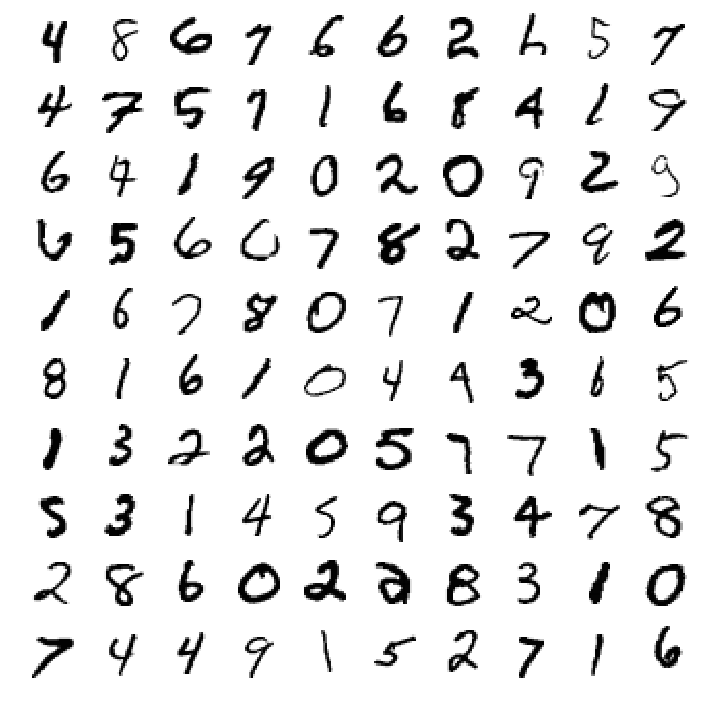

In [11]:
plt.figure(figsize=(12,12))
rand_int = np.random.randint(30000)
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(1-X_train[rand_int+i].reshape((28, 28)), cmap='gray', interpolation='nearest')
    plt.axis('off')
plt.savefig('handwritten_digits.png')

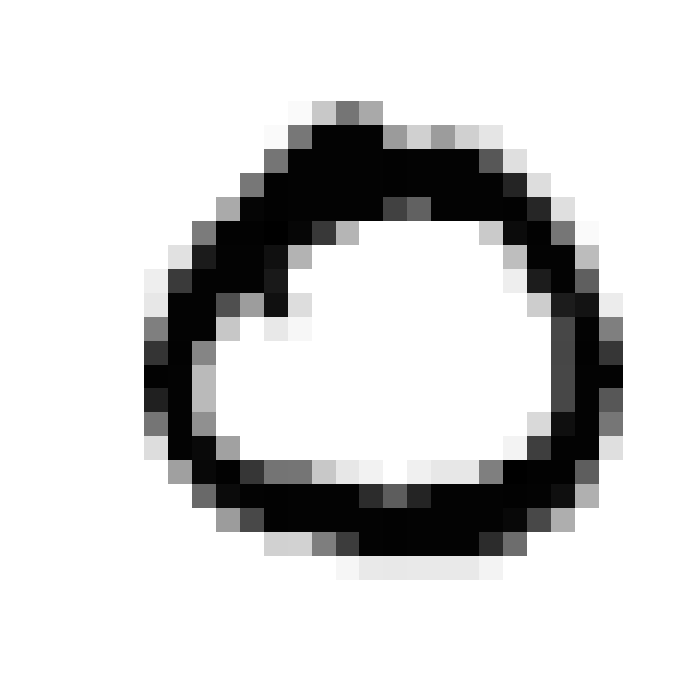

In [25]:
plt.figure(figsize=(12,12))
rand_int = np.random.randint(30000)
plt.imshow(1-X_train[rand_int+i].reshape((28, 28)), cmap='gray', interpolation='nearest')
plt.axis('off')
plt.savefig('single_digit.png')

In [5]:
# We need to reshape from a 1D feature vector to a 1 channel 2D image.
# Then we apply 3 convolutional filters with 3x3 kernel size.
l_in = lasagne.layers.InputLayer(shape=(None, 784))

l_shape = lasagne.layers.ReshapeLayer(l_in, (-1, 1, 28, 28))

l_drop1 = lasagne.layers.DropoutLayer(l_shape,p=0.2)

l_conv1 = lasagne.layers.Conv2DLayer(l_shape, num_filters=3, filter_size=3, pad=1, nonlinearity=lasagne.nonlinearities.rectify)

l_conv2 = lasagne.layers.Conv2DLayer(l_conv1, num_filters=3, filter_size=3, pad=1, nonlinearity=lasagne.nonlinearities.rectify)

l_pool1 = lasagne.layers.MaxPool2DLayer(l_conv2 , pool_size=2)

l_conv3 = lasagne.layers.Conv2DLayer(l_pool1 , num_filters=3, filter_size=3, pad=1, nonlinearity=lasagne.nonlinearities.rectify)

l_conv4 = lasagne.layers.Conv2DLayer(l_conv3 , num_filters=3, filter_size=3, pad=1, nonlinearity=lasagne.nonlinearities.rectify)

l_pool2 = lasagne.layers.MaxPool2DLayer(l_conv4,pool_size=2)

l_conv5 = lasagne.layers.Conv2DLayer(l_pool2 , num_filters=3, filter_size=3, pad=1, nonlinearity=lasagne.nonlinearities.rectify)

l_pool3 = lasagne.layers.MaxPool2DLayer(l_conv5 , pool_size=2)

l_hid1 = lasagne.layers.DenseLayer(l_drop1, num_units=1024,W=lasagne.init.GlorotUniform(),nonlinearity = lasagne.nonlinearities.rectify)

l_drop2 = lasagne.layers.DropoutLayer(l_hid1,p=0.5)

l_hid2 = lasagne.layers.DenseLayer(l_drop2,num_units=1024,W=lasagne.init.GlorotUniform(),nonlinearity = lasagne.nonlinearities.rectify)

l_drop3 = lasagne.layers.DropoutLayer(l_hid2,p=0.5)

l_out = lasagne.layers.DenseLayer(l_drop3,
                                  num_units=10,
                                  nonlinearity=lasagne.nonlinearities.softmax)
max_val = 0

In [6]:
# Compile and train the network.
# Accuracy is much better than the single layer network, despite the small number of filters.
t0 = time.clock()
X_sym = T.matrix()
y_sym = T.ivector()

output = lasagne.layers.get_output(l_out, X_sym)
pred = output.argmax(-1)

loss = T.mean(lasagne.objectives.categorical_crossentropy(output, y_sym))
loss = loss + 0.0001*lasagne.regularization.l1(output)

acc = T.mean(T.eq(pred, y_sym))

params = lasagne.layers.get_all_params(l_out)
grad = T.grad(loss, params)
updates = lasagne.updates.nesterov_momentum(grad, params, learning_rate=0.005,momentum=0.9)

f_train = theano.function([X_sym, y_sym], [loss, acc], updates=updates)
f_val = theano.function([X_sym, y_sym], [loss, acc])
f_predict = theano.function([X_sym], pred)

BATCH_SIZE = 500
N_BATCHES = len(X_train) // BATCH_SIZE
N_VAL_BATCHES = len(X_val) // BATCH_SIZE

train_batches = batch_gen(X_train, y_train, BATCH_SIZE)
val_batches = batch_gen(X_val, y_val, BATCH_SIZE)
print(' ')

log = pd.DataFrame(columns = ('epoch','train loss','val loss', 'ratio','train accuracy','val accuracy','computation duration'))
for epoch in range(100):
    t_epoch = time.clock()
    train_loss = 0
    train_acc = 0
    for _ in range(N_BATCHES):
        X, y = next(train_batches)
        loss, acc = f_train(X, y)
        train_loss += loss
        train_acc += acc
    train_loss /= N_BATCHES
    train_acc /= N_BATCHES

    train_loss 

    val_loss = 0
    val_acc = 0
    for _ in range(N_VAL_BATCHES):
        X, y = next(val_batches)
        loss, acc = f_val(X, y)
        val_loss += loss
        val_acc += acc
    val_loss /= N_VAL_BATCHES
    val_acc /= N_VAL_BATCHES
    
    
    if val_acc > max_val:
        max_val = val_acc
        max_predictions = f_predict(test)
        
    t1=time.clock()-t_epoch
    log.loc[epoch] = [epoch+1,train_loss, val_loss, val_loss/train_loss,train_acc,val_acc,t1]
    
    print('Epoch {}, Train (val) loss {:.03f} ({:.03f}) ratio {:.03f} Train (val) accuracy {:.03f} ({:.03f}) duration {:.01f} seconds'.format(
            epoch+1, train_loss, val_loss, val_loss/train_loss,train_acc, val_acc,t1))
print('total time for neural network is {:.01f} seconds'.format(time.clock()-t0))

predictions = f_predict(test)

 
Epoch 1, Train (val) loss 1.824 (1.197) ratio 0.656 Train (val) accuracy 0.435 (0.667) duration 16.1 seconds
Epoch 2, Train (val) loss 0.915 (0.773) ratio 0.844 Train (val) accuracy 0.737 (0.778) duration 15.4 seconds
Epoch 3, Train (val) loss 0.698 (0.645) ratio 0.924 Train (val) accuracy 0.796 (0.812) duration 15.6 seconds
Epoch 4, Train (val) loss 0.604 (0.586) ratio 0.970 Train (val) accuracy 0.827 (0.834) duration 15.9 seconds
Epoch 5, Train (val) loss 0.564 (0.542) ratio 0.961 Train (val) accuracy 0.841 (0.847) duration 15.3 seconds
Epoch 6, Train (val) loss 0.528 (0.524) ratio 0.991 Train (val) accuracy 0.854 (0.855) duration 16.1 seconds
Epoch 7, Train (val) loss 0.503 (0.501) ratio 0.996 Train (val) accuracy 0.859 (0.861) duration 16.4 seconds
Epoch 8, Train (val) loss 0.479 (0.460) ratio 0.960 Train (val) accuracy 0.868 (0.875) duration 16.1 seconds
Epoch 9, Train (val) loss 0.461 (0.462) ratio 1.002 Train (val) accuracy 0.874 (0.874) duration 12.2 seconds
Epoch 10, Train (

In [58]:
# We can look at the output after the convolutional layer 
filtered = lasagne.layers.get_output(l_shape, X_sym)
f_filter = theano.function([X_sym], filtered)

In [59]:
# Filter the first few training examples
im = f_filter(X_train[:10])
print(im.shape)

(10L, 1L, 28L, 28L)


In [111]:
filtered = lasagne.layers.get_output(l_out, X_sym)
f_filter = theano.function([X_sym], filtered)
im = f_filter(X_train[:10])
print(im.shape)
pic_weights.shape
print((from_photo-np.min(from_photo))*1.0 / (np.max(from_photo) - np.min(from_photo)))

(10L, 10L)
[[ 0.03571429  0.03571429  0.03571429  0.0625      0.01785714  0.01785714
   0.04464286  0.03571429  0.01785714  0.02678571  0.04464286  0.04464286
   0.03571429  0.02678571  0.04464286  0.03571429  0.03571429  0.0625
   0.03571429  0.04464286  0.0625      0.07142857  0.02678571  0.03571429
   0.04464286  0.07142857  0.0625      0.03571429]
 [ 0.01785714  0.03571429  0.07142857  0.03571429  0.03571429  0.00892857
   0.02678571  0.05357143  0.01785714  0.01785714  0.03571429  0.05357143
   0.03571429  0.04464286  0.05357143  0.04464286  0.01785714  0.0625
   0.02678571  0.04464286  0.04464286  0.08928571  0.01785714  0.0625
   0.02678571  0.04464286  0.0625      0.04464286]
 [ 0.02678571  0.01785714  0.03571429  0.04464286  0.00892857  0.00892857
   0.          0.02678571  0.08928571  0.09821429  0.11607143  0.11607143
   0.10714286  0.08035714  0.05357143  0.08035714  0.08035714  0.03571429
   0.0625      0.04464286  0.03571429  0.03571429  0.03571429  0.05357143
   0.044642

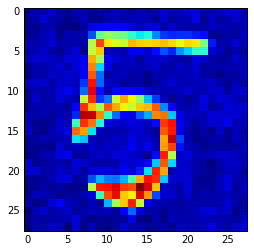

In [85]:

plt.imshow(pic_weights_in, interpolation='nearest')

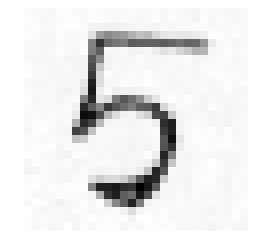

[[  3.21898203e-03   7.14262728e-03   1.44909242e-03   6.60104428e-02
    2.81873833e-02   7.01339371e-01   1.53292648e-01   3.82964966e-02
    4.32248792e-04   6.30708523e-04]] [5]


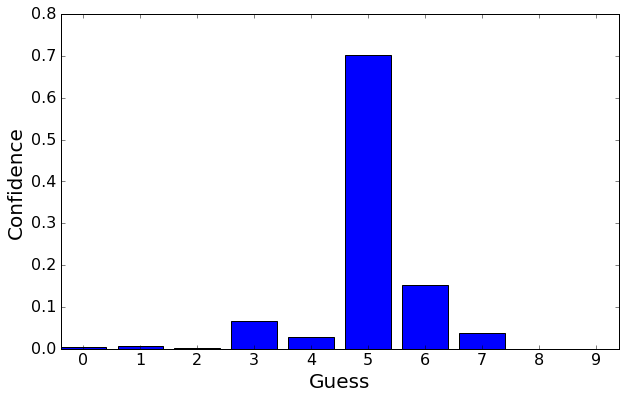

[[ 0.00962628  0.01342975  0.00157692  0.03643885  0.01603769  0.71372912
   0.14789388  0.02499359  0.00642184  0.02985208]]


5

In [114]:
from PIL import Image
im = Image.open("todd_five.png").convert('L')


from_photo=255-np.array(im)
from_photo = (from_photo-np.min(from_photo))*1.0 / (np.max(from_photo)-np.min(from_photo))
plt.imshow(from_photo,cmap = 'Greys', interpolation='nearest')
plt.axis('off')
plt.savefig('clean_five.png')
plt.show()
output = lasagne.layers.get_output(l_out, X_sym)
pic_weights = theano.function([X_sym], output)
pic_weights = pic_weights(from_photo)
input_dummy = lasagne.layers.get_output(l_in, X_sym)
pic_weights_in = theano.function([X_sym], input_dummy)
pic_weights_in = pic_weights_in(from_photo)
print (pic_weights,pic_weights.argmax(-1))
#val_predictions = val_weights.argmax(-1)
plt.figure(figsize=(10,6))
plt.xticks([0.4+i for i in range(10)],('0','1','2','3','4','5','6','7','8','9'),fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Guess',fontsize=20)
plt.ylabel('Confidence',fontsize=20)
plt.bar(range(10),pic_weights[0],0.8)
plt.savefig('wrong_guess_five.png')
plt.show()
output = lasagne.layers.get_output(l_out, X_sym)
predict = theano.function([X_sym], output)
print (predict(from_photo))
f_predict = predict(from_photo).argmax(-1)
f_predict[0]

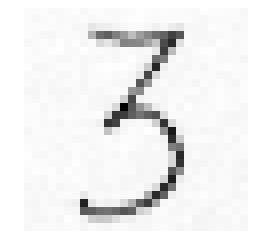

[[ 0.00273717  0.00185896  0.00185697  0.48407     0.00062511  0.45214994
   0.00464627  0.00211585  0.02842365  0.02151609]] [3]


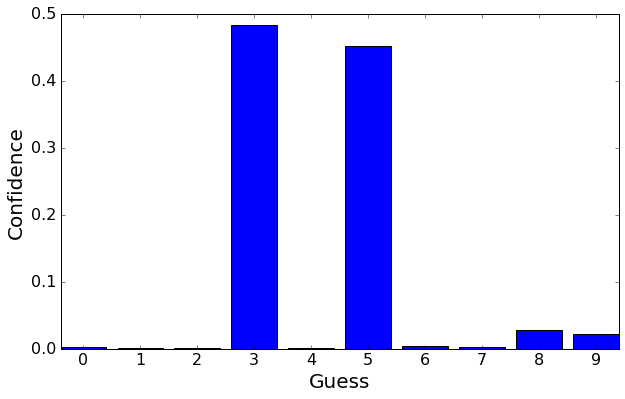

[[  2.33546009e-05   1.65448204e-03   1.11734329e-03   9.51035602e-01
    2.88186345e-04   4.09694424e-02   8.25271895e-04   1.33777642e-04
    2.66728388e-03   1.28525566e-03]]


3

In [113]:
from PIL import Image
im = Image.open("todd_three.png").convert('L')


from_photo=255-np.array(im)
from_photo = (from_photo-np.min(from_photo))*1.0 / (np.max(from_photo)-np.min(from_photo))
plt.imshow(from_photo,cmap = 'Greys', interpolation='nearest')
plt.axis('off')
plt.savefig('clean_three.png')
plt.show()
output = lasagne.layers.get_output(l_out, X_sym)
pic_weights = theano.function([X_sym], output)
pic_weights = pic_weights(from_photo)
input_dummy = lasagne.layers.get_output(l_in, X_sym)
pic_weights_in = theano.function([X_sym], input_dummy)
pic_weights_in = pic_weights_in(from_photo)
print (pic_weights,pic_weights.argmax(-1))
#val_predictions = val_weights.argmax(-1)
plt.figure(figsize=(10,6))
plt.xticks([0.4+i for i in range(10)],('0','1','2','3','4','5','6','7','8','9'),fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Guess',fontsize=20)
plt.ylabel('Confidence',fontsize=20)
plt.bar(range(10),pic_weights[0],0.8)
plt.savefig('wrong_guess_three.png')
plt.show()
output = lasagne.layers.get_output(l_out, X_sym)
predict = theano.function([X_sym], output)
print (predict(from_photo))
f_predict = predict(from_photo).argmax(-1)
f_predict[0]

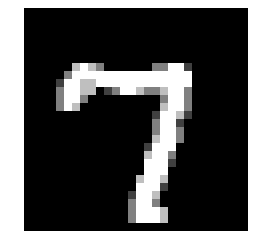

7

In [64]:
dummy = 29
draw_digit(X_val[dummy])
output = lasagne.layers.get_output(l_out, X_sym)
predict = theano.function([X_sym], output)
f_predict = predict(X_val[dummy:dummy+1]).argmax(-1)
f_predict[0]

In [199]:
#val_predictions = f_predict(X_val)
output = lasagne.layers.get_output(l_out, X_sym)
val_weights = theano.function([X_sym], output)
val_weights = val_weights(X_val)
val_predictions = val_weights.argmax(-1)
wrong = [x for x in range(len(X_val)) if val_predictions[x] != y_val[x]]
plt.figure(figsize=(12,6))


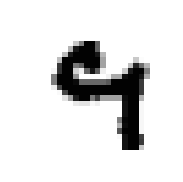

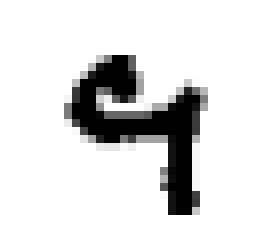

4 [  5.45184994e-22   2.12763274e-17   5.87393998e-16   5.52470885e-10
   6.82788448e-01   5.48683036e-08   3.50209575e-22   1.28447849e-12
   6.20035139e-14   3.17211497e-01]


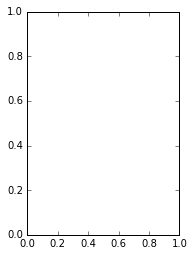

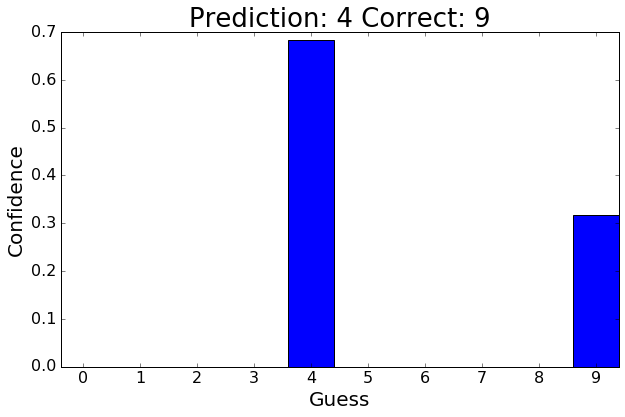

In [228]:
which=26
plt.subplot(1,2,1)
draw_digit(1-X_val[wrong[which]])
plt.imshow(X_val[wrong[which]].reshape((28,28)), cmap='gray_r', interpolation='nearest')
plt.axis('off')
plt.savefig('wrong_guess_pic.png')
plt.show()
print(val_predictions[wrong[which]],val_weights[wrong[which]])
plt.subplot(1,2,2)
filtered = lasagne.layers.get_output(l_out, X_sym)
f_filter = theano.function([X_sym], filtered)
im = f_filter(X_val[wrong[which]:wrong[which]+1])
plt.figure(figsize=(10,6))
plt.xticks([0.4+i for i in range(10)],('0','1','2','3','4','5','6','7','8','9'),fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Guess',fontsize=20)
plt.ylabel('Confidence',fontsize=20)
plt.title('Prediction: {} Correct: {}'.format(val_predictions[wrong[which]], y_val[wrong[which]]),fontsize = 26)
plt.bar(range(10),val_weights[wrong[which]],0.8)
plt.savefig('wrong_guess2.png')
plt.show()



In [14]:
# Rearrange dimension so we can plot the result as RGB images
im = np.rollaxis(np.rollaxis(im, 3, 1), 3, 1)

In [30]:
filtered = lasagne.layers.get_output(l_out, X_sym)
f_filter = theano.function([X_sym], filtered)
im = f_filter(test[:1])
im.shape

(1L, 10L)

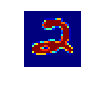

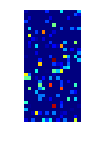

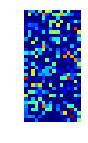

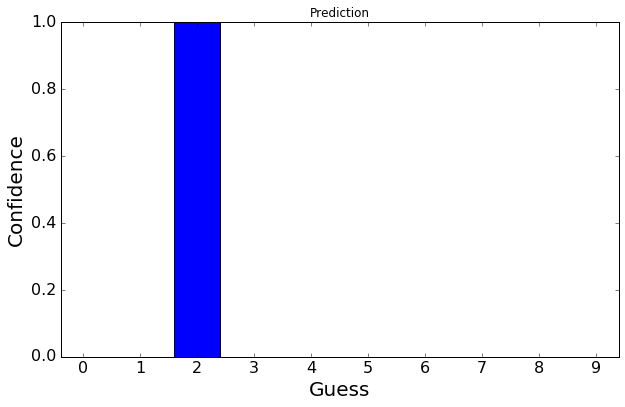

In [8]:
# We can see that each filter seems different features in the images
# ie horizontal / diagonal / vertical segments



def plot_im(im,num_channels):
    for j in range(num_channels):    
        plt.subplot(1, num_channels, j+1)
        plt.imshow(im[0][j], interpolation='nearest')
        plt.axis('off')

filtered = lasagne.layers.get_output(l_shape, X_sym)
f_filter = theano.function([X_sym], filtered)
im = f_filter(test[:1])        
plt.figure(figsize=(1,3))

plot_im(im,1)
plt.savefig('mlp_input.png')
plt.show()
'''

filtered = lasagne.layers.get_output(l_conv1, X_sym)
f_filter = theano.function([X_sym], filtered)
im = f_filter(test[:1])
plt.figure(figsize=(3,3))

plot_im(im,3)
plt.savefig('mlp_1_conv.png')
plt.show()

filtered = lasagne.layers.get_output(l_conv2, X_sym)
f_filter = theano.function([X_sym], filtered)
im = f_filter(test[:1])

plt.figure(figsize=(3,3))
plot_im(im,3)
plt.savefig('mlp_2_conv.png')
plt.show()

filtered = lasagne.layers.get_output(l_pool1, X_sym)
f_filter = theano.function([X_sym], filtered)
im = f_filter(test[:1])

plt.figure(figsize=(3,3))
plot_im(im,3)
plt.savefig('mlp_1_pool.png')
plt.show()

filtered = lasagne.layers.get_output(l_conv3, X_sym)
f_filter = theano.function([X_sym], filtered)
im = f_filter(test[:1])
plt.figure(figsize=(3,3))
plot_im(im,3)
plt.savefig('mlp_3_conv.png')
plt.show()

filtered = lasagne.layers.get_output(l_conv4, X_sym)
f_filter = theano.function([X_sym], filtered)
im = f_filter(test[:1])

plt.figure(figsize=(3,3))
plot_im(im,3)
plt.savefig('deep_cnn_4_conv.png')
plt.show()

filtered = lasagne.layers.get_output(l_pool2, X_sym)
f_filter = theano.function([X_sym], filtered)
im = f_filter(test[:1])

plt.figure(figsize=(3,3))
plot_im(im,3)
plt.savefig('deep_cnn_2_pool.png')
plt.show()
'''
filtered = lasagne.layers.get_output(l_hid1, X_sym)
f_filter = theano.function([X_sym], filtered)
im = f_filter(test[:1])


plt.figure(figsize=(1,3))
plot_im(im.reshape((1,1,32,16)),1)
plt.savefig('mlp_1_hidden.png')
plt.show()

filtered = lasagne.layers.get_output(l_hid2, X_sym)
f_filter = theano.function([X_sym], filtered)
im = f_filter(test[:1])


plt.figure(figsize=(1,3))
plot_im(im.reshape((1,1,32,16)),1)
plt.savefig('mlp_2_hidden.png')
plt.show()

filtered = lasagne.layers.get_output(l_out, X_sym)
f_filter = theano.function([X_sym], filtered)
im = f_filter(test[:1])
plt.figure(figsize=(10,6))
plt.xticks([0.4+i for i in range(10)],('0','1','2','3','4','5','6','7','8','9'),fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Guess',fontsize=20)
plt.ylabel('Confidence',fontsize=20)
plt.title('Prediction')
plt.bar(range(10),im[0],0.8)
plt.savefig('mlp_prediction.png')
plt.show()

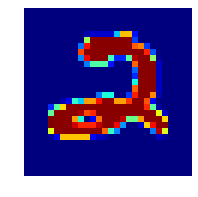

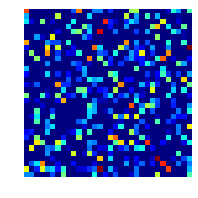

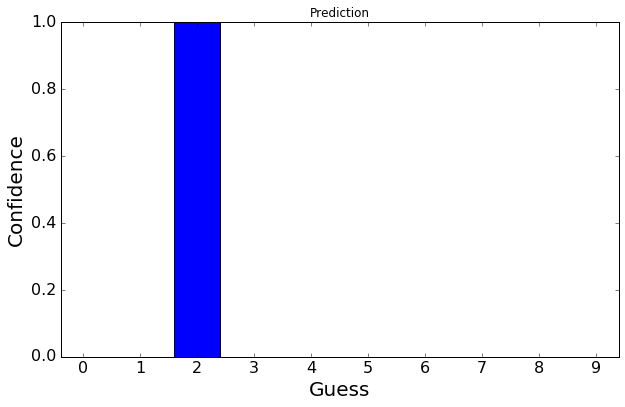

In [8]:
# We can see that each filter seems different features in the images
# ie horizontal / diagonal / vertical segments


def plot_im(im,num_channels):
    for j in range(num_channels):    
        plt.subplot(1, num_channels, j+1)
        plt.imshow(im[0][j], interpolation='nearest')
        plt.axis('off')



filtered = lasagne.layers.get_output(l_shape, X_sym)
f_filter = theano.function([X_sym], filtered)
im = f_filter(test[:1])

plt.figure(figsize=(3,3))
plot_im(im,1)
plt.savefig('nn_input.png')
plt.show()

filtered = lasagne.layers.get_output(l_hid1, X_sym)
f_filter = theano.function([X_sym], filtered)
im = f_filter(test[:1])

plt.figure(figsize=(3,3))
plot_im(im.reshape((1,1,32,32)),1)
plt.savefig('nn_hidden.png')
plt.show()

filtered = lasagne.layers.get_output(l_out, X_sym)
f_filter = theano.function([X_sym], filtered)
im = f_filter(test[:1])
plt.figure(figsize=(10,6))
plt.xticks([0.4+i for i in range(10)],('0','1','2','3','4','5','6','7','8','9'),fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Guess',fontsize=20)
plt.ylabel('Confidence',fontsize=20)
plt.title('Prediction')
plt.bar(range(10),im[0],0.8)
plt.savefig('nn_prediction.png')
plt.show()

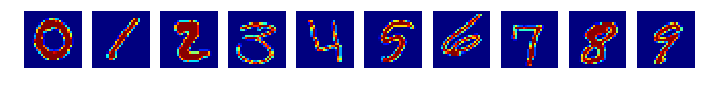

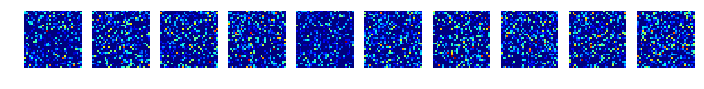

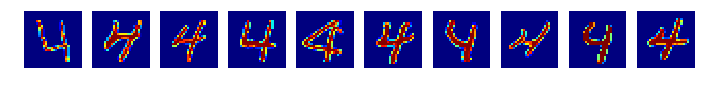

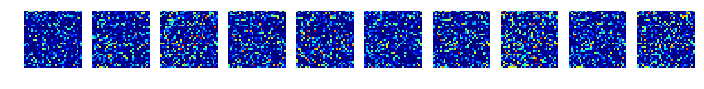

In [55]:
def plot_im(im,num_channels):
    for j in range(num_channels):    
        plt.imshow(im[0][j], interpolation='nearest')
        plt.axis('off')
        
filtered = lasagne.layers.get_output(l_shape, X_sym)
f_filter = theano.function([X_sym], filtered)
val_choice = [0]*10
for j in range(10):
    val_choice[j] = [X_val[i] for i in range(len(X_val)) if y_val[i] ==j]
#val_choice = map(list,zip(*val_choice))
val_select = [0]*10
for j in range(10):
    val_select[j] = val_choice[j][0]
im = f_filter(val_select[:10])


plt.figure(figsize=(12,3))

for i in range(10):
    plt.subplot(1,10,i+1)
    plot_im(im[i].reshape((1,1,28,28)),1)
plt.savefig('nn_demo_input.png')
plt.show()

filtered = lasagne.layers.get_output(l_hid1, X_sym)
f_filter = theano.function([X_sym], filtered)
for j in range(10):
    val_choice[j] = [X_val[i] for i in range(len(X_val)) if y_val[i] ==j]
val_select = [0]*10
for j in range(10):
    val_select[j] = val_choice[j][0]
im = f_filter(val_select[:10])

plt.figure(figsize=(12,3))
for i in range(10):
    plt.subplot(1,10,i+1)
    plot_im(im[i].reshape((1,1,32,32)),1)
plt.savefig('nn_demo_hidden.png')
plt.show()

filtered = lasagne.layers.get_output(l_shape, X_sym)
f_filter = theano.function([X_sym], filtered)
val_choice = [0]*10
for j in range(10):
    val_choice[j] = [X_val[i] for i in range(len(X_val)) if y_val[i] ==j]
#val_choice = map(list,zip(*val_choice))
val_select = [0]*10
for j in range(10):
    val_select[j] = val_choice[4][j]
im = f_filter(val_select[:10])


plt.figure(figsize=(12,3))

for i in range(10):
    plt.subplot(1,10,i+1)
    plot_im(im[i].reshape((1,1,28,28)),1)
plt.savefig('nn_demo2_input.png')
plt.show()

filtered = lasagne.layers.get_output(l_hid1, X_sym)
f_filter = theano.function([X_sym], filtered)
for j in range(10):
    val_choice[j] = [X_val[i] for i in range(len(X_val)) if y_val[i] ==j]
val_select = [0]*10
for j in range(10):
    val_select[j] = val_choice[4][j]
im = f_filter(val_select[:10])

plt.figure(figsize=(12,3))
for i in range(10):
    plt.subplot(1,10,i+1)
    plot_im(im[i].reshape((1,1,32,32)),1)
plt.savefig('nn_demo2_hidden.png')
plt.show()


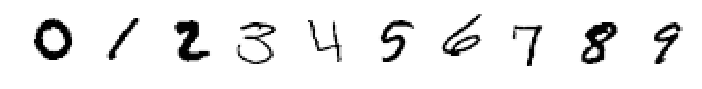

In [12]:
def plot_im(im,num_channels):
    for j in range(num_channels):    
        plt.imshow(im[0][j], cmap = 'Greys',interpolation='nearest')
        plt.axis('off')
        
filtered = lasagne.layers.get_output(l_shape, X_sym)
f_filter = theano.function([X_sym], filtered)
val_choice = [0]*10
for j in range(10):
    val_choice[j] = [X_val[i] for i in range(len(X_val)) if y_val[i] ==j]
#val_choice = map(list,zip(*val_choice))
val_select = [0]*10
for j in range(10):
    val_select[j] = val_choice[j][0]
im = f_filter(val_select[:10])


plt.figure(figsize=(12,3))

for i in range(10):
    plt.subplot(1,10,i+1)
    plot_im(im[i].reshape((1,1,28,28)),1)
plt.savefig('nn_demo_input_grey.png')
plt.show()

In [46]:
np.array(val_select).shape

(793L, 784L)

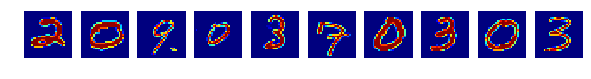

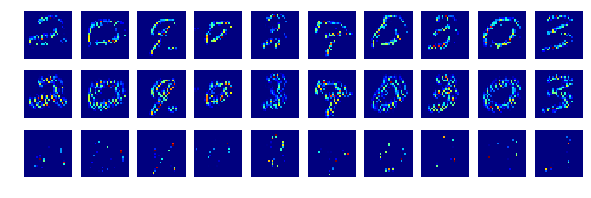

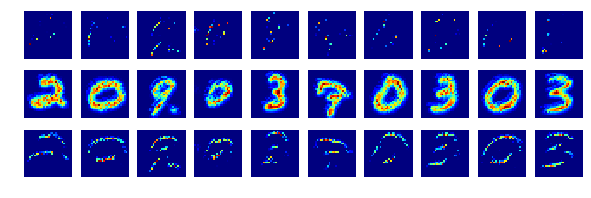

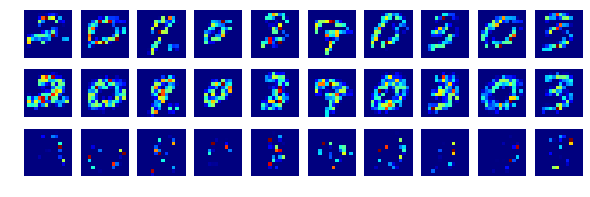

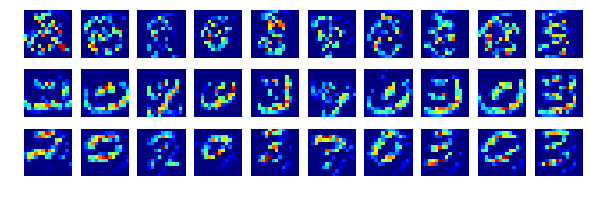

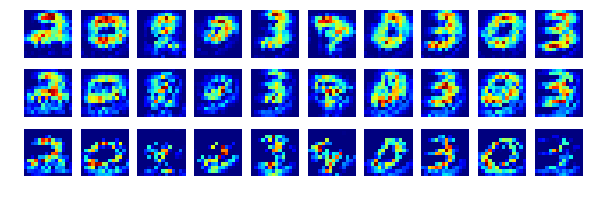

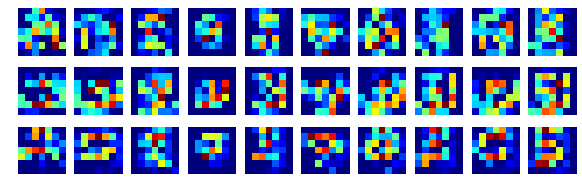

ValueError: total size of new array must be unchanged

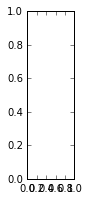

In [19]:
'''# We can see that each filter seems different features in the images
# ie horizontal / diagonal / vertical segments

filtered = lasagne.layers.get_output(l_shape, X_sym)
f_filter = theano.function([X_sym], filtered)
im = f_filter(test[:10])

plt.figure(figsize=(10,3))
index = 0
for i in range(10):        
    index+=1
    plt.subplot(1,10, index)
    plt.imshow(im[i][0], interpolation='nearest')
    plt.axis('off')
plt.savefig('deep_cnn_input.png')
plt.show()


filtered = lasagne.layers.get_output(l_conv1, X_sym)
f_filter = theano.function([X_sym], filtered)
im = f_filter(test[:10])

plt.figure(figsize=(10,3))
index = 0
for j in range(3):
    for i in range(10):        
        index+=1
        plt.subplot(3, 10, index)
        plt.imshow(im[i][j], interpolation='nearest')
        plt.axis('off')
plt.savefig('deep_cnn_1_conv.png')
plt.show()

filtered = lasagne.layers.get_output(l_conv2, X_sym)
f_filter = theano.function([X_sym], filtered)
im = f_filter(test[:10])

plt.figure(figsize=(10,3))
index = 0
for j in range(3):
    for i in range(10):        
        index+=1
        plt.subplot(3, 10, index)
        plt.imshow(im[i][j], interpolation='nearest')
        plt.axis('off')
plt.savefig('deep_cnn_2_conv.png')
plt.show()

filtered = lasagne.layers.get_output(l_pool1, X_sym)
f_filter = theano.function([X_sym], filtered)
im = f_filter(test[:10])

plt.figure(figsize=(10,3))
index = 0
for j in range(3):
    for i in range(10):        
        index+=1
        plt.subplot(3, 10, index)
        plt.imshow(im[i][j], interpolation='nearest')
        plt.axis('off')
plt.savefig('deep_cnn_1_pool.png')
plt.show()

filtered = lasagne.layers.get_output(l_conv3, X_sym)
f_filter = theano.function([X_sym], filtered)
im = f_filter(test[:10])

plt.figure(figsize=(10,3))
index = 0
for j in range(3):
    for i in range(10):        
        index+=1
        plt.subplot(3, 10, index)
        plt.imshow(im[i][j], interpolation='nearest')
        plt.axis('off')
plt.savefig('deep_cnn_3_conv.png')
plt.show()

filtered = lasagne.layers.get_output(l_conv4, X_sym)
f_filter = theano.function([X_sym], filtered)
im = f_filter(test[:10])

plt.figure(figsize=(10,3))
index = 0
for j in range(3):
    for i in range(10):        
        index+=1
        plt.subplot(3, 10, index)
        plt.imshow(im[i][j], interpolation='nearest')
        plt.axis('off')
plt.savefig('deep_cnn_4_conv.png')
plt.show()

filtered = lasagne.layers.get_output(l_pool2, X_sym)
f_filter = theano.function([X_sym], filtered)
im = f_filter(test[:10])

plt.figure(figsize=(10,3))
index = 0
for j in range(3):
    for i in range(10):        
        index+=1
        plt.subplot(3, 10, index)
        plt.imshow(im[i][j], interpolation='nearest')
        plt.axis('off')
plt.savefig('deep_cnn_2_pool.png')
plt.show()

filtered = lasagne.layers.get_output(l_hid1, X_sym)
f_filter = theano.function([X_sym], filtered)
im = f_filter(test[:10])

plt.figure(figsize=(10,3))
index = 0
for i in range(10):        
    index+=1
    plt.subplot(1,10, index)
    plt.imshow(im[i].reshape((16,8)), interpolation='nearest')
    plt.axis('off')
plt.savefig('deep_cnn_hidden.png')
plt.show()

filtered = lasagne.layers.get_output(l_out, X_sym)
f_filter = theano.function([X_sym], filtered)
im = f_filter(test[:10])
plt.figure(figsize=(10,9))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.plot(im[i],'o')
plt.savefig('deep_cnn_prediction.png')
plt.show()
'''

In [62]:
output = lasagne.layers.get_output(l_out, X_sym)
raw_out = theano.function([X_sym], output)
pred_weights = raw_out(test)
pred_weights[100:110]

array([[  1.00000000e+000,   0.00000000e+000,   0.00000000e+000,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
          0.00000000e+000],
       [  0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
          1.00000000e+000],
       [  0.00000000e+000,   0.00000000e+000,   1.00000000e+000,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
          0.00000000e+000],
       [  1.00000000e+000,   0.00000000e+000,   0.00000000e+000,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
          0.00000000e+000],
       [  0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
          0.00000000e+000,   0.00000000e+00

In [8]:
#save results
np.savetxt('simple_nn.csv',np.c_[range(1,len(test)+1),predictions],delimiter=',',header = 'ImageId,Label', comments = '',fmt='%d')
np.savetxt('simple_nn_max.csv',np.c_[range(1,len(test)+1),max_predictions],delimiter=',',header = 'ImageId,Label', comments = '',fmt='%d')
log.to_csv("simple_nn_log.csv")

In [15]:
#save results
np.savetxt('simple_nn_dropout.csv',np.c_[range(1,len(test)+1),predictions],delimiter=',',header = 'ImageId,Label', comments = '',fmt='%d')
np.savetxt('simple_nn_dropout_max.csv',np.c_[range(1,len(test)+1),max_predictions],delimiter=',',header = 'ImageId,Label', comments = '',fmt='%d')
log.to_csv("simple_nn_log.csv")

In [17]:
#save results
np.savetxt('Deep_nn.csv',np.c_[range(1,len(test)+1),predictions],delimiter=',',header = 'ImageId,Label', comments = '',fmt='%d')
np.savetxt('Deep_nn_max.csv',np.c_[range(1,len(test)+1),max_predictions],delimiter=',',header = 'ImageId,Label', comments = '',fmt='%d')

In [7]:
#save results
np.savetxt('Deep_cnn.csv',np.c_[range(1,len(test)+1),predictions],delimiter=',',header = 'ImageId,Label', comments = '',fmt='%d')
np.savetxt('Deep_cnn_max.csv',np.c_[range(1,len(test)+1),max_predictions],delimiter=',',header = 'ImageId,Label', comments = '',fmt='%d')
log.to_csv("Deep_cnn_log.csv")

In [8]:
#save results
np.savetxt('cnn_channels.csv',np.c_[range(1,len(test)+1),predictions],delimiter=',',header = 'ImageId,Label', comments = '',fmt='%d')
np.savetxt('cnn_channels_max.csv',np.c_[range(1,len(test)+1),max_predictions],delimiter=',',header = 'ImageId,Label', comments = '',fmt='%d')
log.to_csv("cnn_channels_log.csv")

In [10]:
#save results
np.savetxt('mlp_channels.csv',np.c_[range(1,len(test)+1),predictions],delimiter=',',header = 'ImageId,Label', comments = '',fmt='%d')
np.savetxt('mlp_channels_max.csv',np.c_[range(1,len(test)+1),max_predictions],delimiter=',',header = 'ImageId,Label', comments = '',fmt='%d')
log.to_csv("mlp_log.csv")

In [9]:
log

,epoch,train loss,val loss,ratio,train accuracy,val accuracy,computation duration
0,1,2.341231,2.312773,0.987845,0.170265,0.235750,21.248979
1,2,1.707503,0.746289,0.437065,0.448029,0.778000,20.653733
2,3,0.562923,0.453935,0.806390,0.838265,0.871875,21.113097
3,4,0.397857,0.353762,0.889169,0.891500,0.907625,21.822802
4,5,0.322150,0.303847,0.943187,0.915794,0.920750,21.012054
5,6,0.281180,0.264948,0.942272,0.926941,0.933000,20.966611
6,7,0.257546,0.264720,1.027856,0.935059,0.935500,20.567036
7,8,0.237803,0.253694,1.066823,0.941059,0.938625,20.306764
8,9,0.228556,0.230757,1.009633,0.945618,0.942750,20.605561
9,10,0.207140,0.234282,1.131030,0.950971,0.942125,17.032428


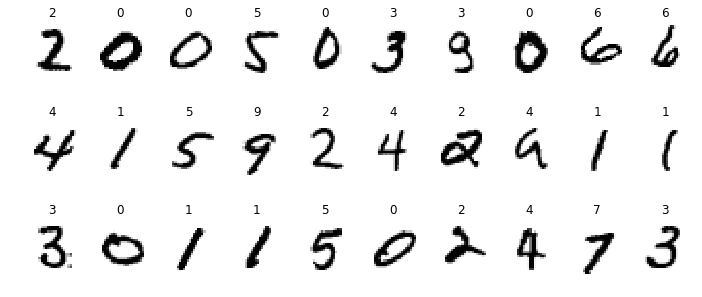

In [36]:
plt.figure(figsize=(12,5))
rand_int = np.random.randint(30000)
for i in range(30):
    plt.subplot(3, 10, i+1)
    plt.imshow(255.-test[rand_int+i].reshape((28, 28)), cmap='gray', interpolation='nearest')
    plt.title(str(max_predictions[rand_int+i]))
    plt.axis('off')

304 309


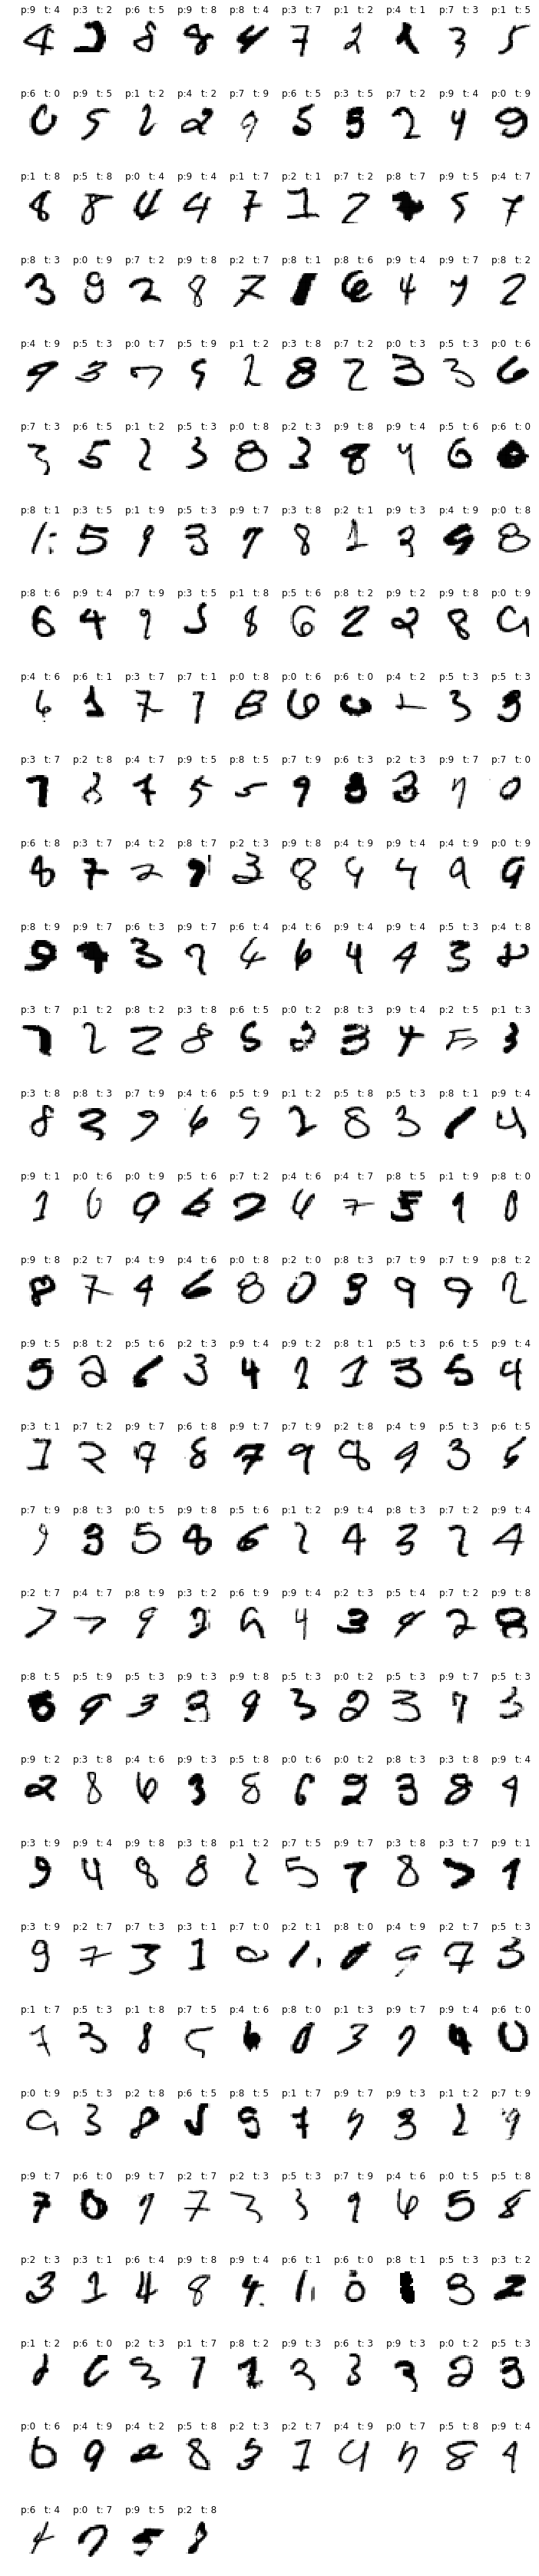

In [10]:
val_predictions = f_predict(X_val)
output = lasagne.layers.get_output(l_out, X_sym)
val_weights = theano.function([X_sym], output)
val_weights = val_weights(X_val)
wrong = [x for x in range(len(X_val)) if val_predictions[x] != y_val[x]]
wrong2 = [i for i in range(8000) if val_weights[i].argmax(-1) != y_val[i]]
print (len(wrong),len(wrong2))
#for i in range(len(X_val)):
#    if max_predictions[i] != y_val[i]:
plt.figure(figsize=(12,len(wrong)/5))
count = 0
for i in wrong:
    count +=1
    plt.subplot(len(wrong)/10+1, 10, count)
    plt.imshow(255.-X_val[i].reshape((28, 28)), cmap='gray', interpolation='nearest')
    plt.title('p:' + str(val_predictions[i])+'   t: ' + str(y_val[i]) )
    plt.axis('off')
plt.show()


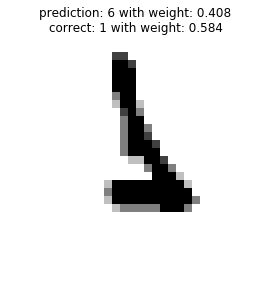

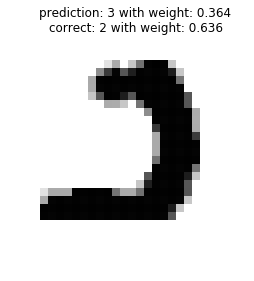

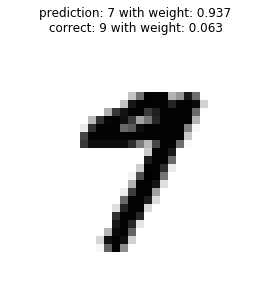

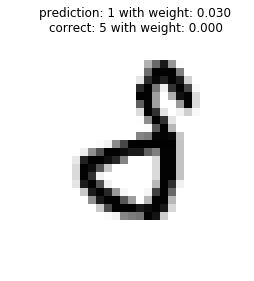

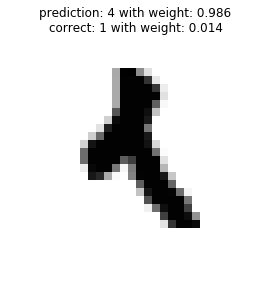

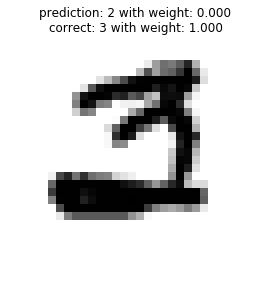

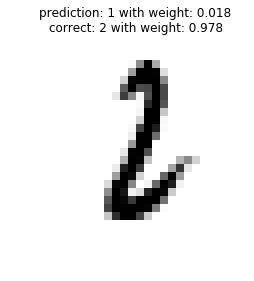

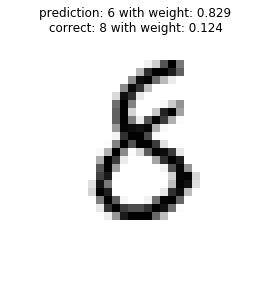

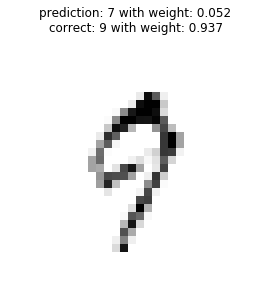

In [55]:
from textwrap import wrap
output = lasagne.layers.get_output(l_out, X_sym)
raw_out = theano.function([X_sym], output)
val_weights = raw_out(X_val)
count = 0
for i in wrong:
    count +=1
    if count ==10:
        break
#    print ('prediction: {} with weight: {:.03f}   correct: {} with weight: {:.03f}'.format(val_predictions[i],
#                val_weights[i][val_predictions[i]], y_val[i],val_weights[i][y_val[i]]))
    plt.imshow(255.-X_val[i].reshape((28, 28)), cmap='gray', interpolation='nearest')
    plt.title("\n".join(wrap('prediction: {} with weight: {:.03f}   correct: {} with weight: {:.03f}'.format(val_predictions[i],
                val_weights[i][val_predictions[i]], y_val[i],val_weights[i][y_val[i]]),35)))
    plt.axis('off')
    plt.show()

    
    

8 6 [  8.83415744e-007   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   9.99999117e-001   0.00000000e+000
   2.80170249e-118   0.00000000e+000]


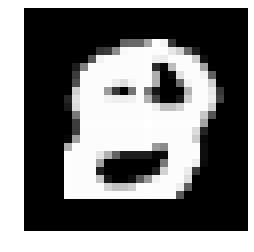

5 9 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]


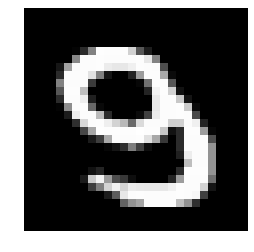

9 8 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   4.01114070e-222   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.00000000e+000   3.45785559e-113]


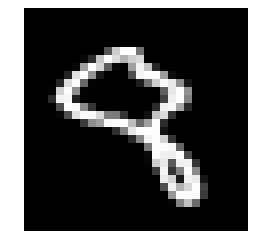

3 5 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   3.33203485e-101
   0.00000000e+000   1.00000000e+000   0.00000000e+000   1.50881100e-266
   0.00000000e+000   0.00000000e+000]


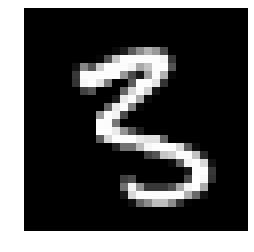

5 4 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]


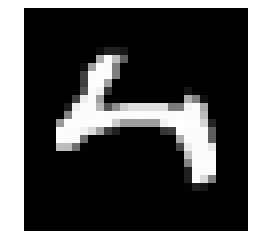

4 8 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   9.12385633e-048   0.00000000e+000   0.00000000e+000   3.43804407e-302
   1.00000000e+000   2.32569125e-186]


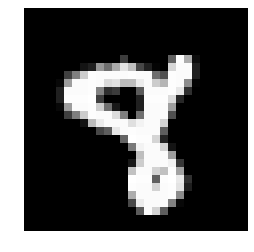

7 4 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.00000000e+000   0.00000000e+000   2.07652885e-303   0.00000000e+000
   0.00000000e+000   0.00000000e+000]


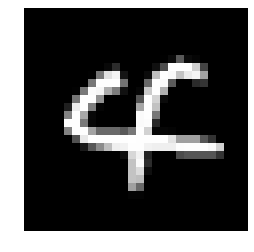

4 9 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.81452218e-15   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   1.00000000e+00]


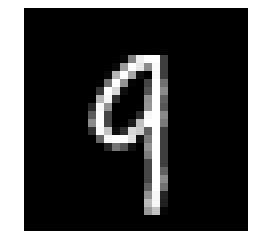

4 9 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   3.80334629e-70   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   1.00000000e+00]


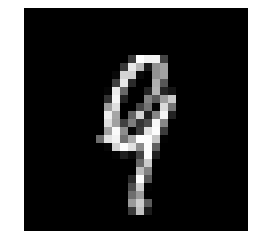

8 3 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   1.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   4.72485149e-258
   0.00000000e+000   0.00000000e+000]


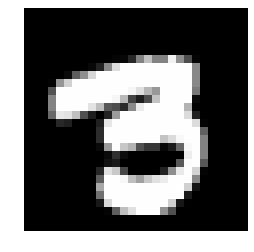

9 4 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.87820043e-111]


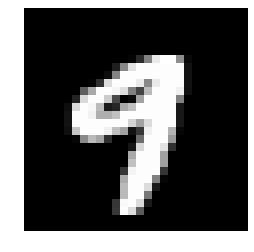

3 7 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   3.23364188e-54
   0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
   0.00000000e+00   0.00000000e+00]


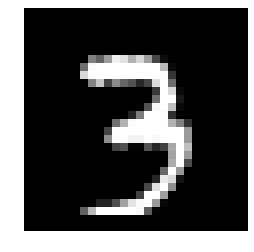

5 3 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]


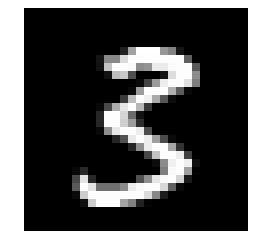

5 7 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


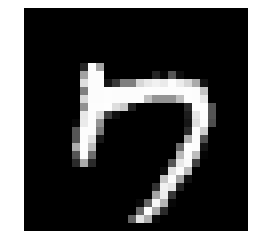

8 5 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.00000000e+000   6.35595406e-137   0.00000000e+000
   4.70861180e-217   0.00000000e+000]


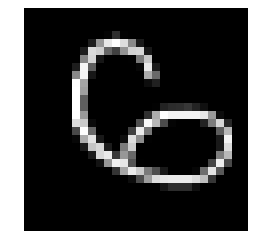

7 9 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   4.89699561e-112
   0.00000000e+000   1.00000000e+000]


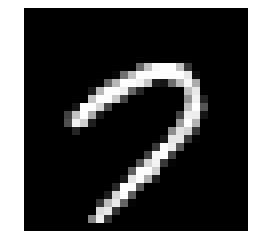

8 5 [ 0.          0.          0.          0.          0.          0.99806507
  0.          0.          0.00193493  0.        ]


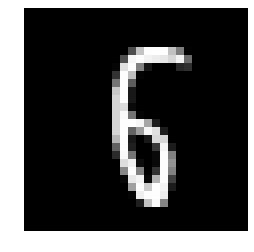

4 7 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   6.37450093e-54   0.00000000e+00   0.00000000e+00   1.00000000e+00
   0.00000000e+00   0.00000000e+00]


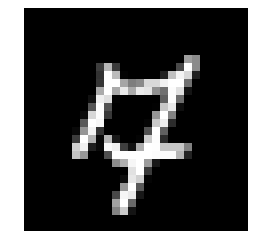

6 0 [  1.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.01636895e-035   0.00000000e+000   1.64307218e-113   0.00000000e+000
   0.00000000e+000   2.62490267e-239]


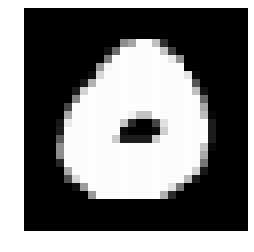

0 6 [  9.07157794e-308   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   1.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000]


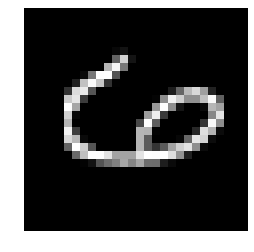

6 5 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.00000000e+000   2.64811609e-151   0.00000000e+000
   0.00000000e+000   0.00000000e+000]


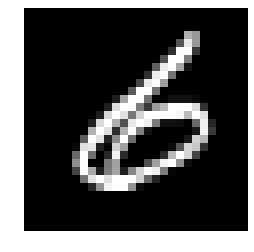

0 9 [  3.61551644e-029   0.00000000e+000   2.41066411e-243   5.44193970e-288
   1.12341522e-057   0.00000000e+000   2.65335743e-103   0.00000000e+000
   1.55278591e-195   1.00000000e+000]


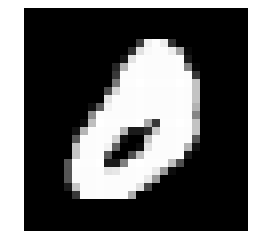

1 7 [  0.00000000e+000   0.00000000e+000   4.98106247e-291   0.00000000e+000
   2.24764942e-272   0.00000000e+000   0.00000000e+000   1.00000000e+000
   4.24941810e-116   1.16302337e-142]


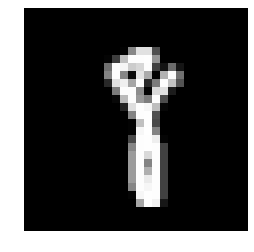

5 3 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
   0.00000000e+00   4.05962624e-16   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00]


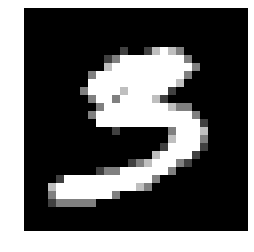

1 2 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]


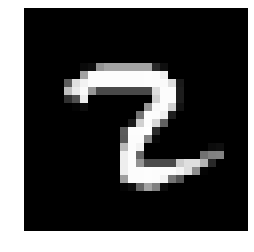

0 3 [  0.00000000e+000   0.00000000e+000   2.80634008e-031   1.00000000e+000
   0.00000000e+000   9.48470200e-112   1.29642893e-012   0.00000000e+000
   0.00000000e+000   0.00000000e+000]


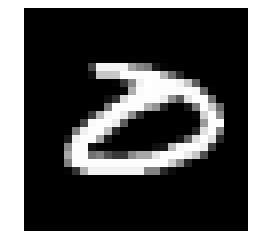

7 9 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.27537525e-166   0.00000000e+000   0.00000000e+000   4.64660926e-031
   0.00000000e+000   1.00000000e+000]


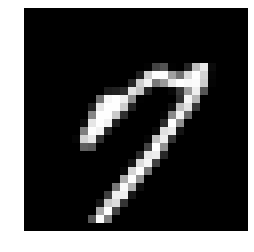

8 4 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.00000000e+000   1.13964077e-065   0.00000000e+000   0.00000000e+000
   9.39900766e-206   0.00000000e+000]


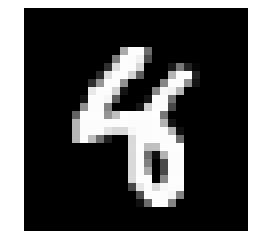

8 1 [  8.94936673e-241   1.00000000e+000   1.35160185e-232   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.00611811e-139   0.00000000e+000]


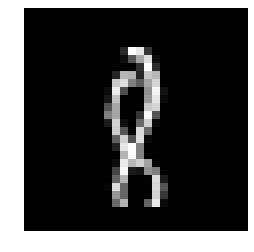

4 9 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.43989160e-40   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   1.00000000e+00]


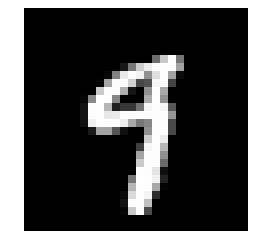

9 4 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.82191446e-191]


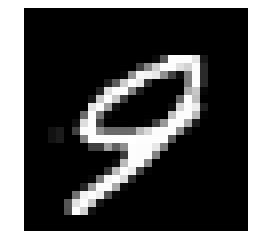

8 5 [  0.00000000e+000   6.67868191e-191   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.00000000e+000   0.00000000e+000   0.00000000e+000
   8.17949620e-059   0.00000000e+000]


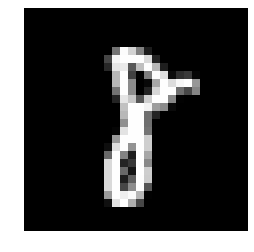

1 8 [  6.62937740e-166   1.28703771e-034   0.00000000e+000   0.00000000e+000
   8.35013174e-271   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.00000000e+000   0.00000000e+000]


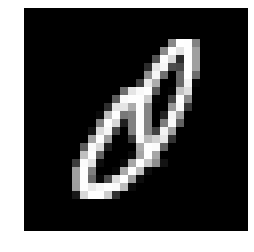

1 5 [  0.00000000e+000   2.15056045e-254   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.00000000e+000   2.45372068e-252   0.00000000e+000
   0.00000000e+000   0.00000000e+000]


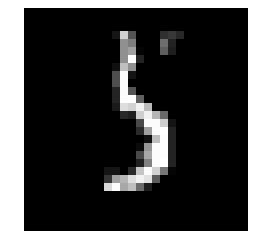

4 7 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   3.79119891e-110   0.00000000e+000   0.00000000e+000   1.00000000e+000
   0.00000000e+000   0.00000000e+000]


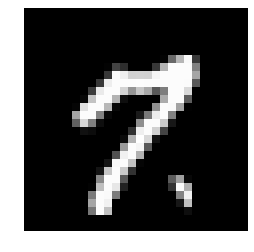

9 4 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   2.88982606e-68]


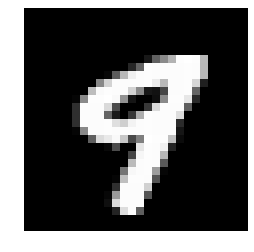

3 2 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]


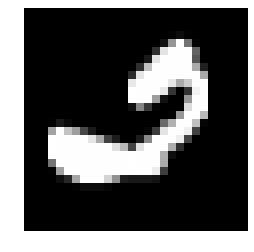

9 4 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   6.59833947e-28]


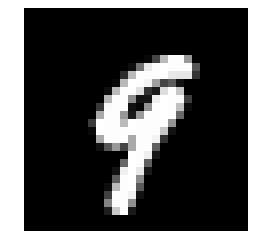

4 9 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   7.07319799e-25   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   1.00000000e+00]


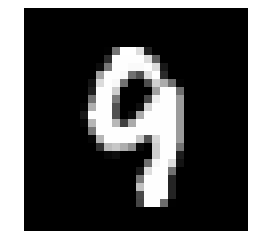

9 4 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   8.62593799e-36]


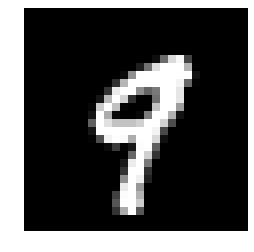

4 9 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   2.29549446e-18   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   1.00000000e+00]


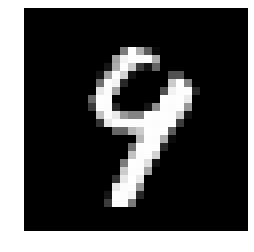

9 4 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   2.53249046e-145   1.36751962e-032]


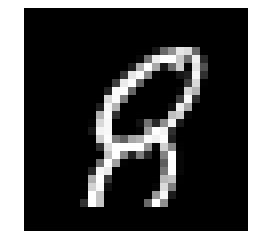

9 4 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   2.48044832e-264]


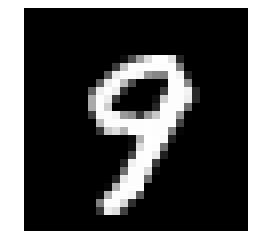

3 5 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   9.35311908e-07
   0.00000000e+00   9.99999065e-01   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00]


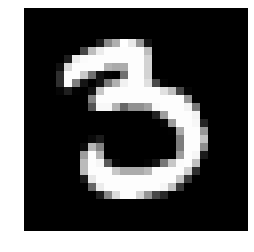

9 7 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
   0.00000000e+00   9.54274403e-74]


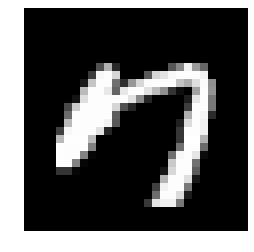

5 8 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   9.84780310e-181   0.00000000e+000   0.00000000e+000
   1.00000000e+000   0.00000000e+000]


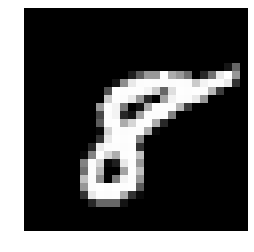

4 8 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.33217987e-63   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00]


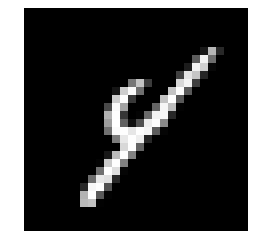

9 5 [  6.64138448e-62   1.77898810e-09   0.00000000e+00   1.49229882e-78
   5.89032819e-16   9.99999998e-01   0.00000000e+00   5.19401993e-22
   0.00000000e+00   4.75270969e-83]


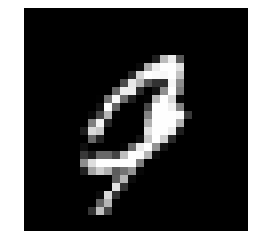

1 5 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.00000000e+000   1.23921919e-247   0.00000000e+000
   0.00000000e+000   0.00000000e+000]


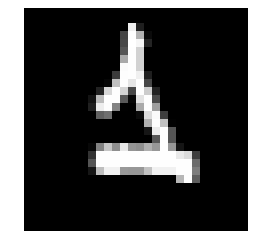

6 8 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


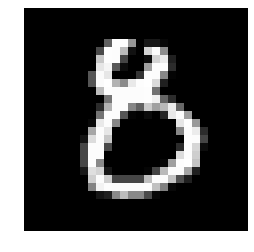

9 7 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   1.00000000e+000
   7.80238092e-245   3.08416993e-286]


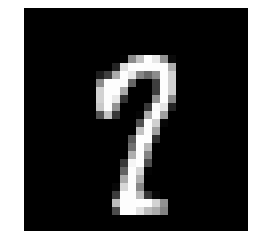

5 9 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]


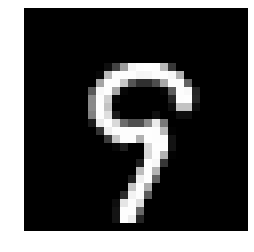

4 9 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   2.20243899e-80   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   1.00000000e+00]


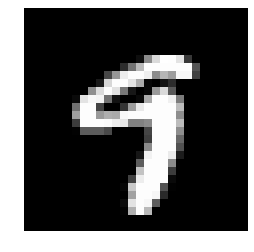

7 4 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.00000000e+000   0.00000000e+000   0.00000000e+000   2.08765338e-281
   0.00000000e+000   0.00000000e+000]


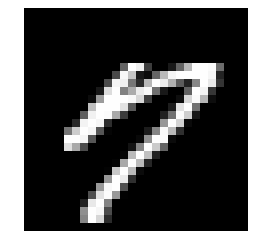

4 9 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   9.16722877e-280   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.00000000e+000]


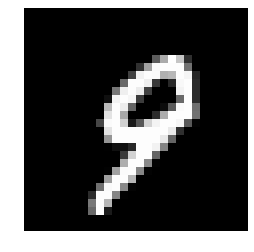

3 5 [  2.41438083e-273   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.00000000e+000   6.53784870e-157   0.00000000e+000
   0.00000000e+000   2.26167966e-185]


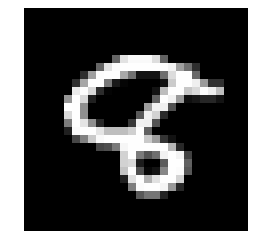

3 5 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   5.53648836e-229
   0.00000000e+000   1.00000000e+000   0.00000000e+000   8.64417509e-045
   0.00000000e+000   0.00000000e+000]


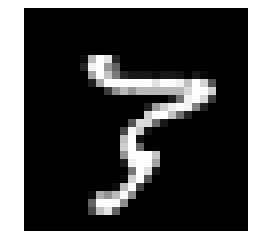

5 8 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   3.27194862e-308   0.00000000e+000   0.00000000e+000
   1.00000000e+000   0.00000000e+000]


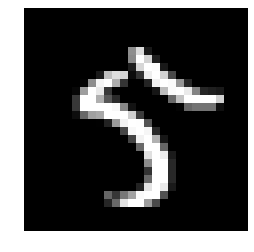

6 5 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]


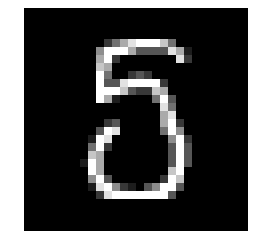

4 9 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   6.76782514e-271   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.00000000e+000]


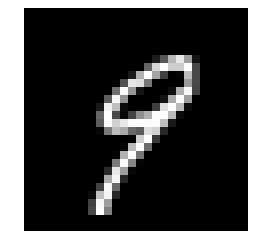

7 9 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.41411270e-59
   0.00000000e+00   1.00000000e+00]


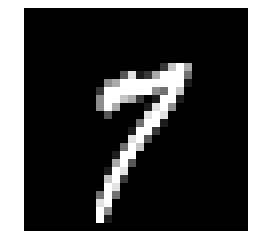

9 4 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   5.63515946e-41]


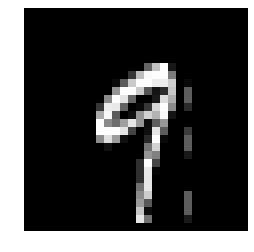

7 2 [  0.00000000e+000   5.76346758e-295   1.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   5.59466574e-129
   0.00000000e+000   0.00000000e+000]


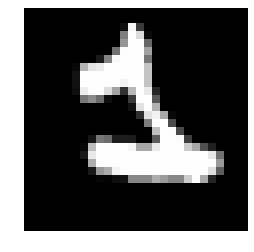

8 9 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   1.60028577e-217
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   5.86485158e-164   1.00000000e+000]


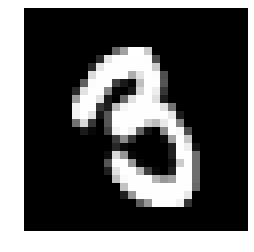

4 9 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]


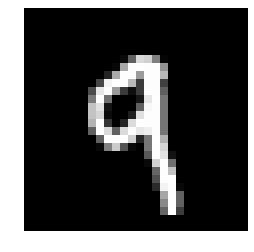

3 2 [ 0.          0.          0.99487938  0.00512062  0.          0.          0.
  0.          0.          0.        ]


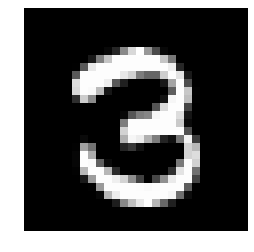

4 9 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]


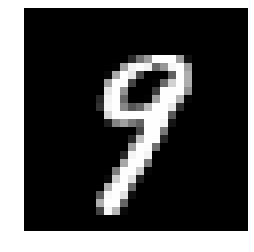

9 4 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.46063801e-237]


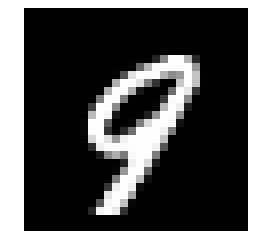

1 8 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


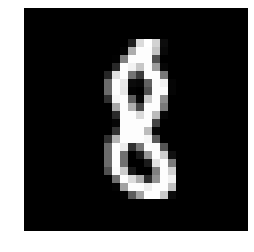

3 5 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   2.62166079e-33
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00]


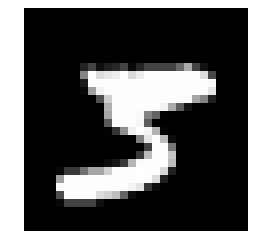

4 8 [  0.00000000e+000   2.31398456e-296   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.00000000e+000   0.00000000e+000]


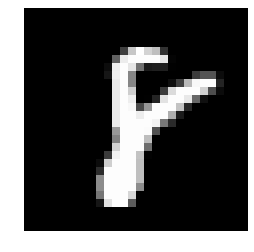

4 9 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   5.71600981e-223   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.00000000e+000]


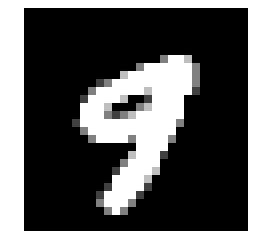

1 9 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   2.15146016e-37
   0.00000000e+00   1.00000000e+00]


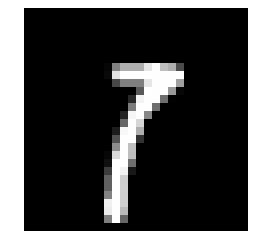

9 5 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]


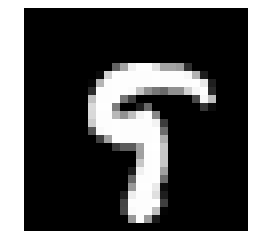

7 3 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]


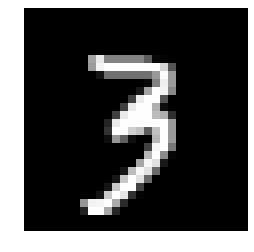

4 9 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   2.09345076e-187   0.00000000e+000   0.00000000e+000   3.34612028e-150
   0.00000000e+000   1.00000000e+000]


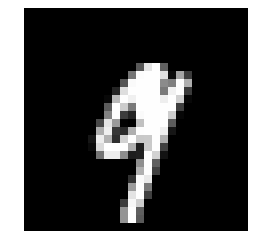

8 2 [  5.27562312e-084   1.40282156e-120   1.00000000e+000   5.32832561e-284
   0.00000000e+000   0.00000000e+000   4.61444536e-293   0.00000000e+000
   3.15276289e-018   0.00000000e+000]


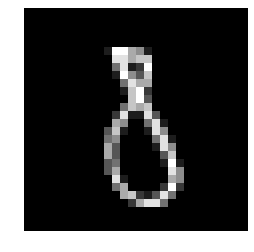

7 3 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]


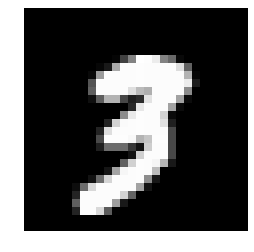

2 0 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


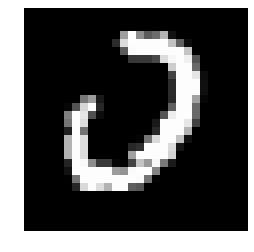

3 5 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   2.53855875e-105
   0.00000000e+000   1.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000]


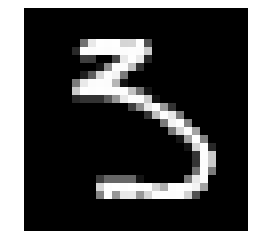

4 9 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   7.32556938e-54   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   1.00000000e+00]


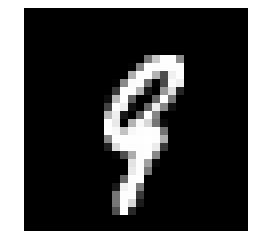

6 5 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   1.00000000e+00   4.88812066e-28   0.00000000e+00
   0.00000000e+00   0.00000000e+00]


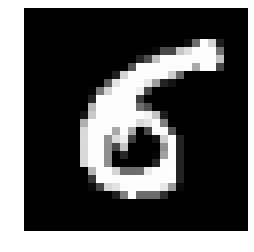

3 2 [  0.00000000e+000   0.00000000e+000   1.00000000e+000   1.34864891e-240
   0.00000000e+000   0.00000000e+000   0.00000000e+000   3.06106540e-050
   0.00000000e+000   0.00000000e+000]


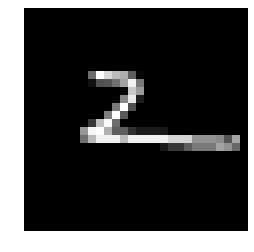

4 9 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   2.10671155e-76   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   1.00000000e+00]


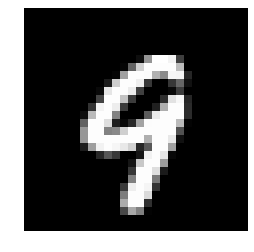

0 9 [  2.08366176e-297   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.00000000e+000]


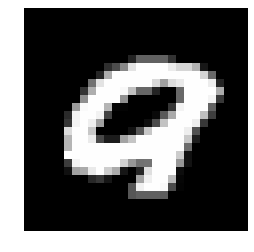

8 6 [  5.04168143e-148   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.29790743e-136   1.00000000e+000   0.00000000e+000
   3.45991987e-063   0.00000000e+000]


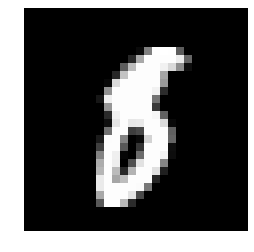

9 4 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   9.99988137e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   1.18626579e-05]


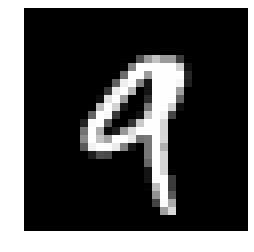

8 5 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.00000000e+000   0.00000000e+000   0.00000000e+000
   1.45221453e-194   3.79993649e-133]


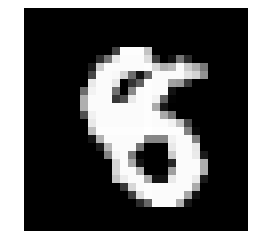

4 9 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   4.41220293e-120   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.00000000e+000]


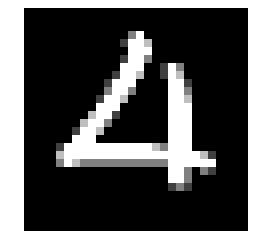

4 9 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.97041975e-238   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.00000000e+000]


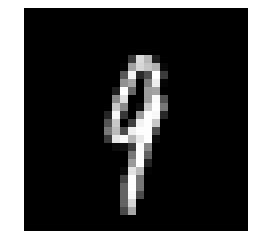

9 7 [ 0.         0.         0.         0.         0.         0.         0.
  0.9900996  0.         0.0099004]


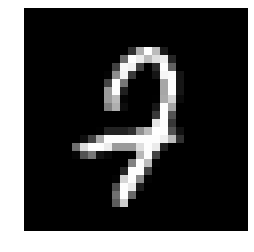

4 8 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


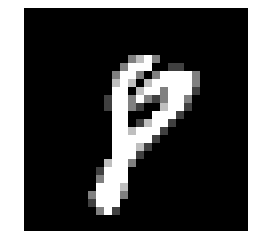

9 4 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.96114764e-106]


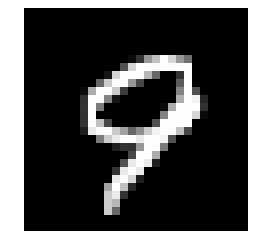

9 8 [  0.00000000e+000   0.00000000e+000   2.70431716e-271   7.23086007e-171
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.00000000e+000   2.02671342e-096]


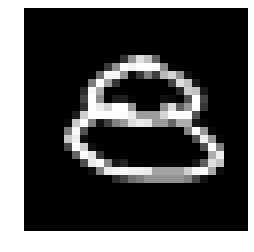

7 9 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]


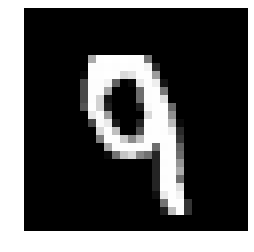

7 9 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   5.60945953e-86
   0.00000000e+00   1.00000000e+00]


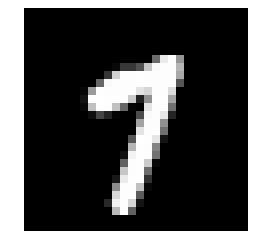

7 9 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   1.09741001e-101
   0.00000000e+000   1.00000000e+000]


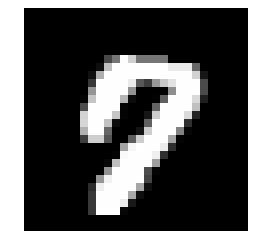

8 3 [  1.02850369e-256   0.00000000e+000   0.00000000e+000   1.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   2.57611965e-135   0.00000000e+000]


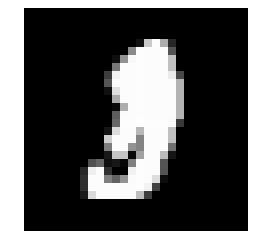

7 1 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]


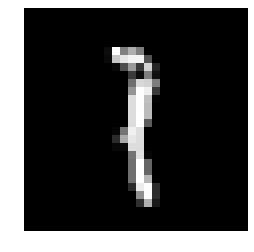

0 2 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]


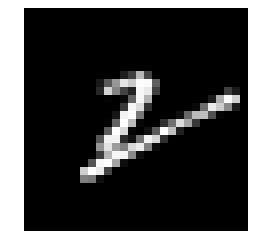

4 9 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   5.40823638e-70   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   1.00000000e+00]


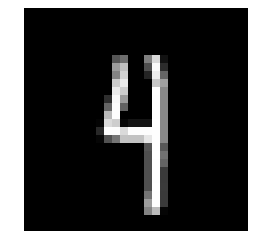

8 9 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   5.01257661e-250   0.00000000e+000
   3.92589581e-217   1.00000000e+000]


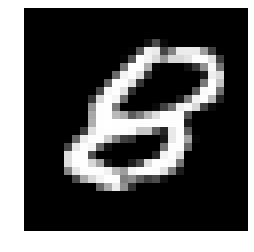

4 9 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   6.93994345e-252   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.00000000e+000]


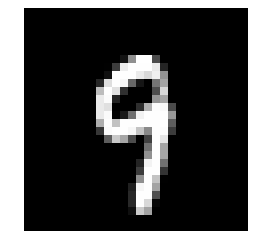

9 8 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   4.72497988e-161   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.00000000e+000   9.39859084e-056]


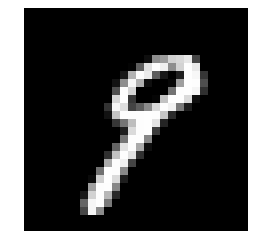

7 4 [  0.00000000e+000   1.52295231e-220   0.00000000e+000   0.00000000e+000
   1.00000000e+000   0.00000000e+000   0.00000000e+000   2.73346206e-098
   4.54290136e-148   0.00000000e+000]


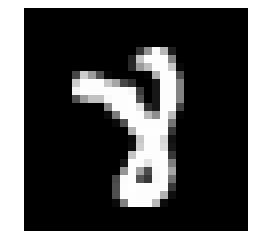

2 0 [  1.00000000e+000   0.00000000e+000   1.61147870e-208   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000]


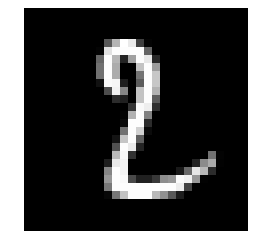

0 8 [  8.81219135e-216   0.00000000e+000   8.16476226e-294   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.00000000e+000   0.00000000e+000]


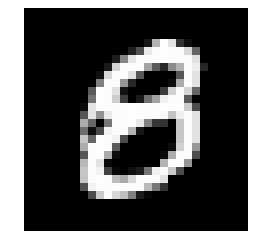

9 4 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]


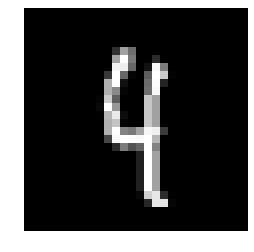

6 4 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   4.09272135e-79]


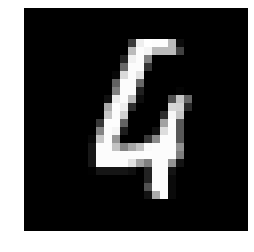

1 8 [  0.00000000e+00   5.04901134e-85   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00]


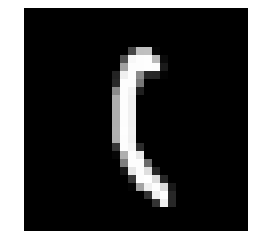

4 9 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.38942832e-192   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.00000000e+000]


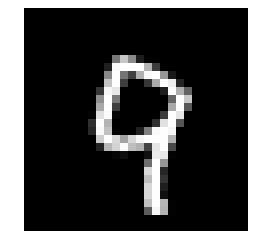

3 2 [  0.00000000e+000   0.00000000e+000   1.00000000e+000   9.37145554e-205
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000]


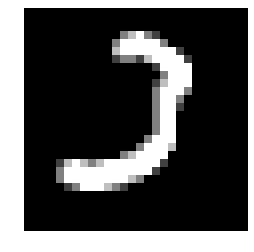

2 7 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


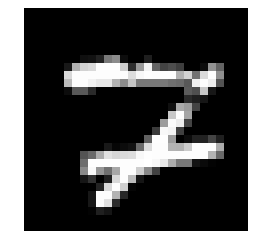

0 2 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]


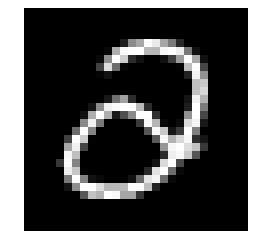

4 9 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]


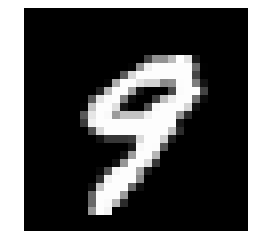

9 4 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]


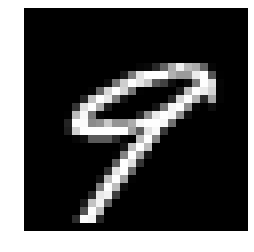

3 8 [  3.51103542e-296   0.00000000e+000   1.00092467e-086   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   6.27678228e-233
   1.00000000e+000   0.00000000e+000]


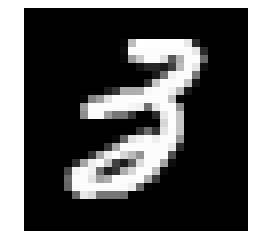

5 6 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   9.07320979e-010   9.99999999e-001   0.00000000e+000
   1.55105471e-224   0.00000000e+000]


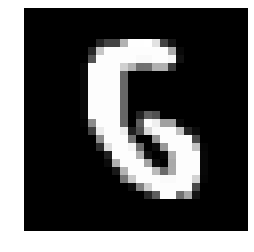

5 3 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   1.00000000e+000
   0.00000000e+000   7.80480024e-187   0.00000000e+000   0.00000000e+000
   0.00000000e+000   3.15716629e-169]


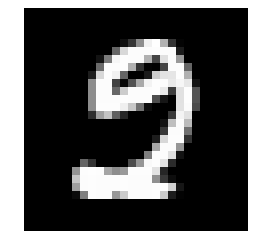

3 5 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]


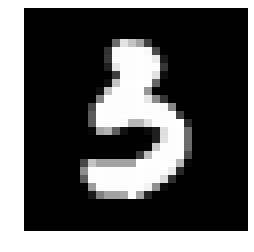

9 4 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   4.18029738e-92]


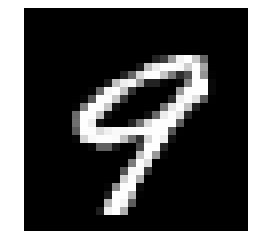

3 5 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   2.27582512e-179
   0.00000000e+000   1.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000]


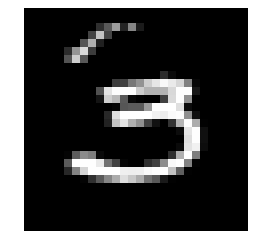

5 9 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]


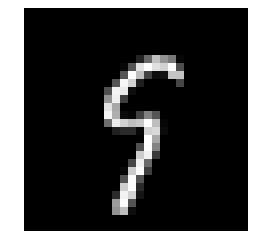

7 2 [  0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   6.96468058e-43
   0.00000000e+00   0.00000000e+00]


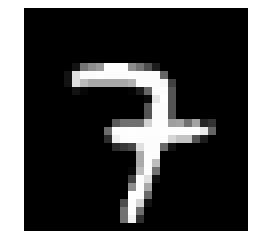

9 4 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   2.20323372e-47]


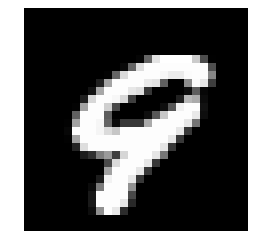

4 9 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   3.60567288e-90   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   1.00000000e+00]


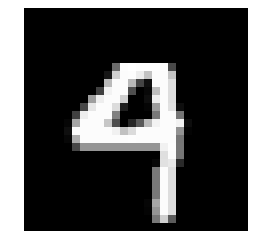

6 4 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   3.71558288e-27   0.00000000e+00
   0.00000000e+00   0.00000000e+00]


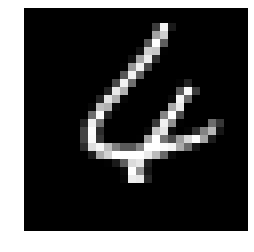

8 5 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.00000000e+000   2.60219579e-040   0.00000000e+000
   6.37263533e-145   0.00000000e+000]


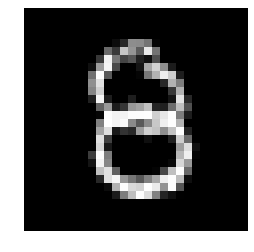

2 7 [  0.00000000e+000   0.00000000e+000   3.51019440e-077   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   1.00000000e+000
   2.46533833e-244   0.00000000e+000]


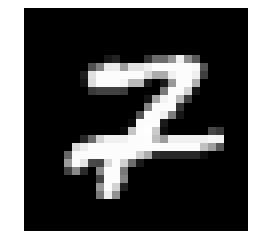

4 9 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   2.17414219e-129   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.00000000e+000]


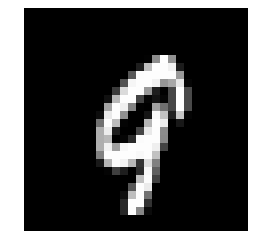

2 6 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]


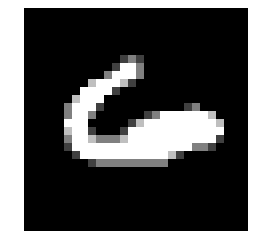

2 0 [  1.00000000e+000   0.00000000e+000   0.00000000e+000   1.35940209e-147
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   4.43165855e-281   0.00000000e+000]


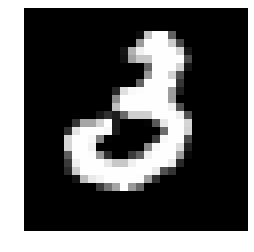

3 5 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   9.11813908e-09
   0.00000000e+00   9.99999991e-01   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00]


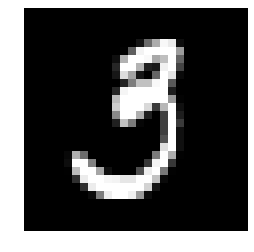

2 3 [  0.00000000e+000   0.00000000e+000   2.29930810e-279   1.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000]


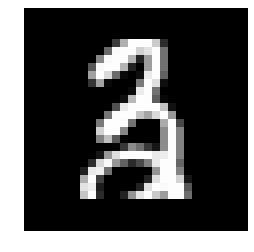

8 6 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   1.62192131e-127
   1.05403829e-087   1.22490342e-017   1.00000000e+000   0.00000000e+000
   4.42488489e-193   0.00000000e+000]


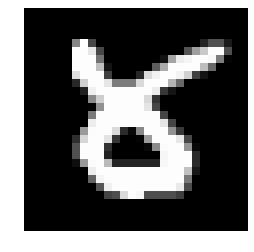

5 8 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.34097276e-130   5.74379732e-155   0.00000000e+000
   1.00000000e+000   0.00000000e+000]


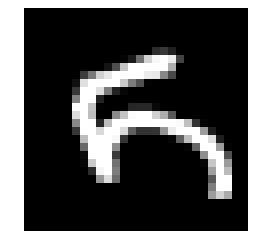

9 4 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   9.72663705e-140]


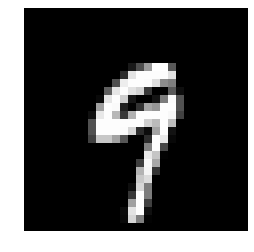

9 7 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
   0.00000000e+00   1.04766799e-19]


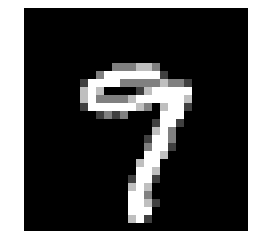

9 7 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


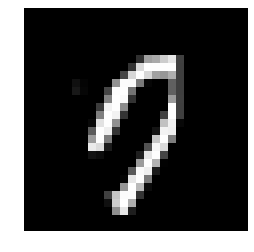

7 2 [  0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   2.66923600e-69
   0.00000000e+00   0.00000000e+00]


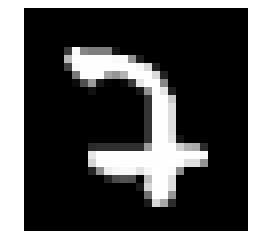

0 8 [  5.38240819e-308   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   1.10610474e-143   0.00000000e+000
   1.00000000e+000   0.00000000e+000]


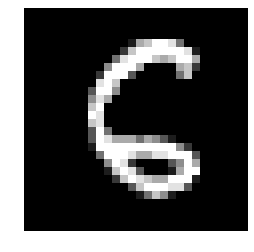

6 0 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


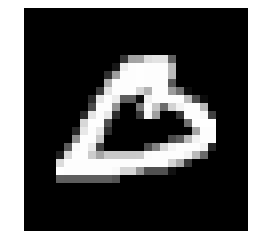

3 5 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   6.65426166e-272
   0.00000000e+000   1.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000]


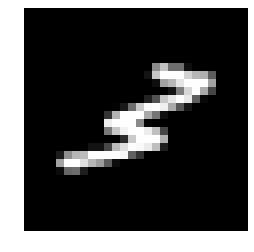

2 4 [  0.00000000e+00   0.00000000e+00   8.69715941e-84   0.00000000e+00
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00]


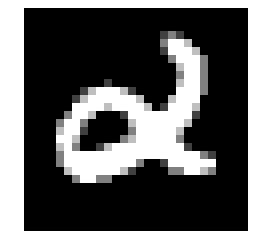

6 5 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]


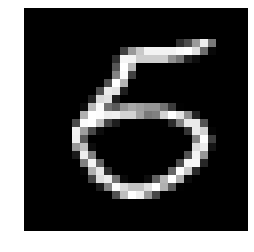

5 8 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


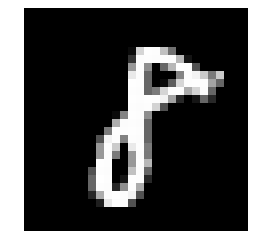

9 4 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   3.01578268e-220]


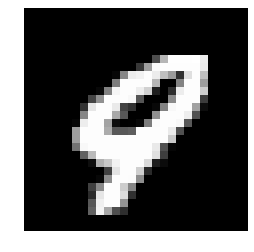

0 8 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.00000000e+000   8.53740004e-298]


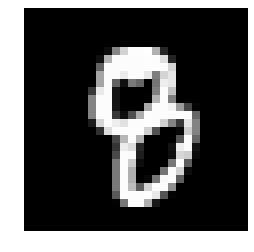

4 9 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]


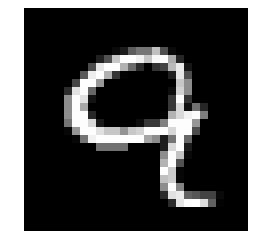

8 5 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.00000000e+000   0.00000000e+000   0.00000000e+000
   1.65591458e-284   0.00000000e+000]


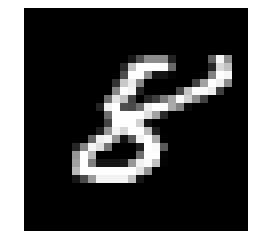

3 2 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]


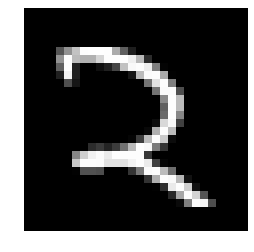

0 8 [  3.73179485e-025   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.29081015e-290   0.00000000e+000   0.00000000e+000   4.19415019e-196
   1.00000000e+000   0.00000000e+000]


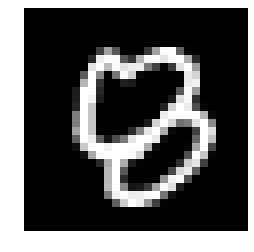

1 8 [  0.00000000e+000   8.31840450e-136   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.00000000e+000   0.00000000e+000]


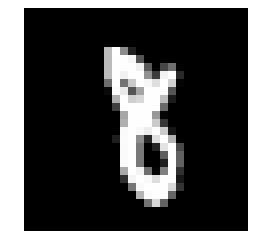

5 8 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


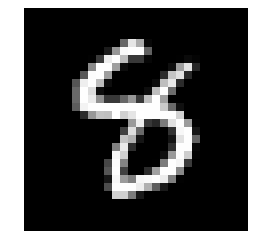

1 2 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]


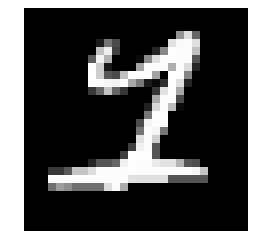

1 2 [  0.00000000e+000   4.98151028e-248   1.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   1.04555086e-206
   0.00000000e+000   0.00000000e+000]


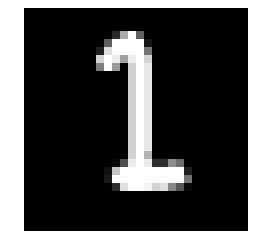

5 3 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   1.00000000e+000
   0.00000000e+000   4.28389133e-194   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000]


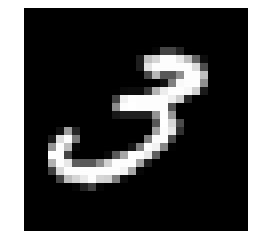

0 6 [  2.82551612e-022   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   2.68923267e-226   1.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000]


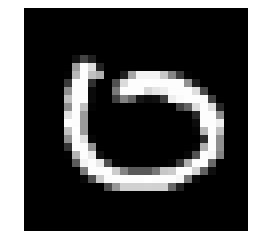

7 8 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   4.00475151e-062   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.00000000e+000   7.36810695e-198]


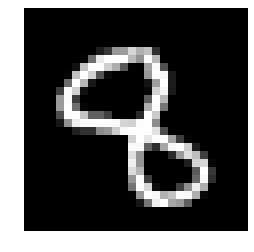

8 6 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]


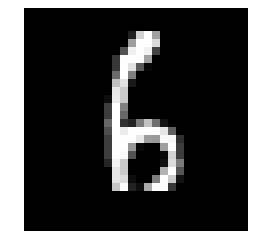

8 6 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   2.51456203e-303   1.00000000e+000   0.00000000e+000
   1.04661715e-141   0.00000000e+000]


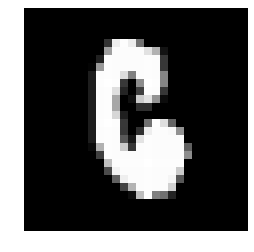

4 9 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.53933480e-146   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.00000000e+000]


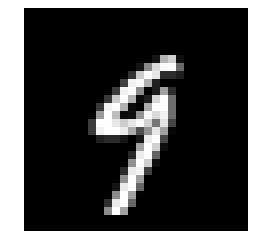

1 8 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


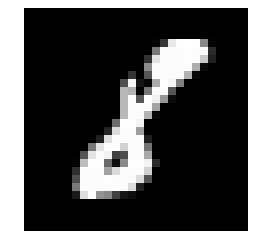

5 6 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   5.33300647e-259   1.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000]


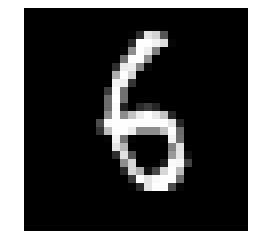

4 9 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   2.48826662e-297   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.00000000e+000]


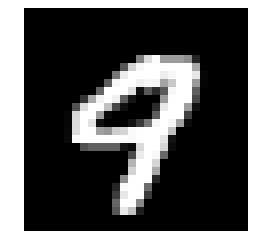

2 7 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


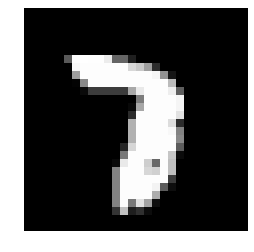

3 8 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


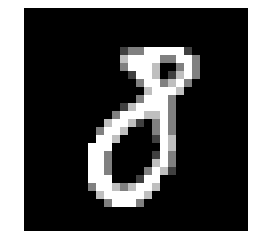

5 3 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
   0.00000000e+00   1.05898156e-60   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00]


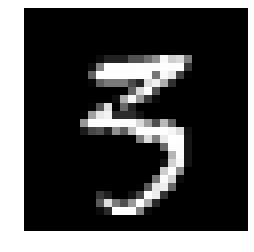

0 4 [  6.57707076e-92   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   1.43016105e-43   0.00000000e+00
   0.00000000e+00   4.79809849e-50]


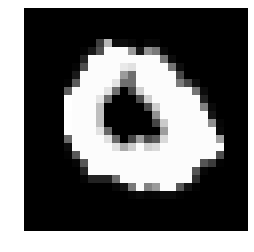

7 8 [  0.00000000e+000   4.55584197e-206   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   5.05737294e-240
   1.00000000e+000   0.00000000e+000]


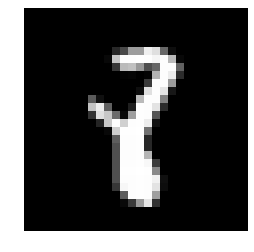

8 9 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   7.57015508e-305   1.00000000e+000]


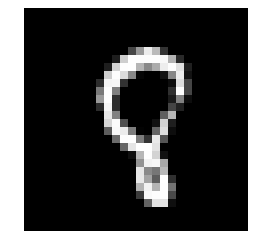

9 7 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   1.00000000e+000
   0.00000000e+000   2.90088025e-137]


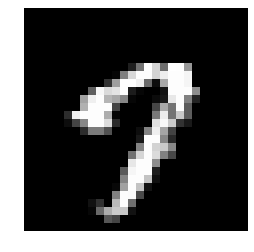

8 6 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   9.31985398e-121   1.00000000e+000   0.00000000e+000
   3.97244953e-027   0.00000000e+000]


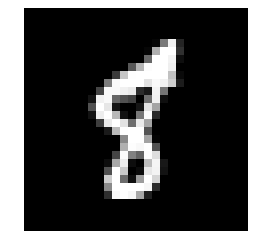

5 6 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.30215754e-149   1.00000000e+000   0.00000000e+000
   3.39152357e-280   0.00000000e+000]


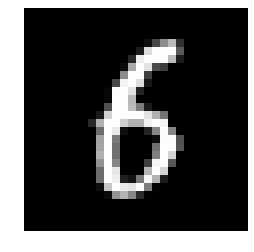

4 9 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   9.36899310e-97   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   1.00000000e+00]


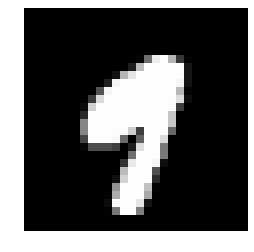

9 4 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   2.09729562e-25]


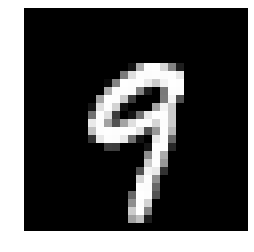

8 5 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.00000000e+000   0.00000000e+000   0.00000000e+000
   3.04178943e-266   0.00000000e+000]


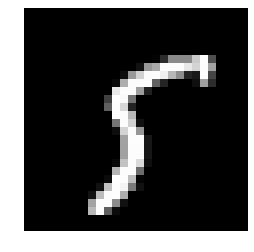

3 9 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   3.54248131e-050
   5.37263768e-137   5.54124417e-128   0.00000000e+000   4.46325711e-248
   0.00000000e+000   1.00000000e+000]


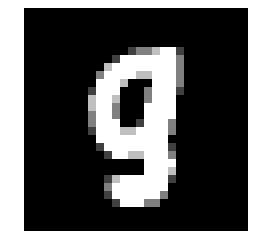

9 0 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


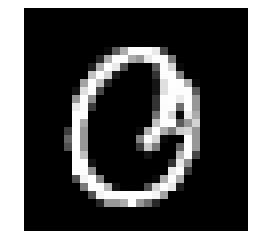

4 5 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   1.00000000e+00   1.24960002e-64   0.00000000e+00
   0.00000000e+00   0.00000000e+00]


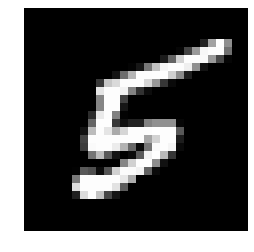

8 2 [  0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   7.92139516e-47   0.00000000e+00]


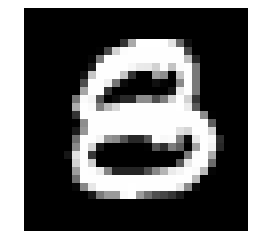

4 9 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]


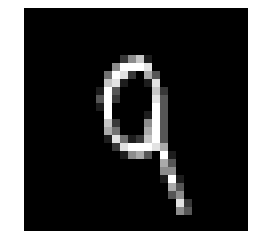

9 4 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]


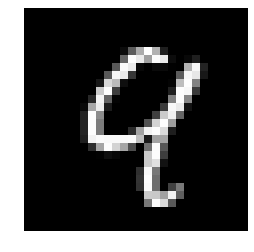

6 5 [  7.77606031e-265   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.00000000e+000   3.72078619e-148   0.00000000e+000
   0.00000000e+000   0.00000000e+000]


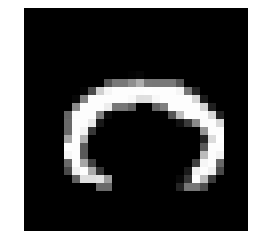

6 0 [  1.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   7.78202390e-194   0.00000000e+000
   0.00000000e+000   0.00000000e+000]


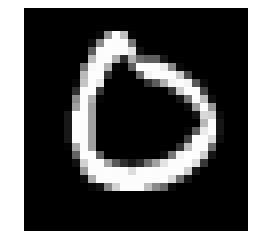

9 4 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   2.26455453e-107]


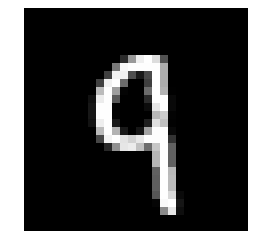

2 7 [  0.00000000e+00   0.00000000e+00   5.71870785e-60   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
   0.00000000e+00   0.00000000e+00]


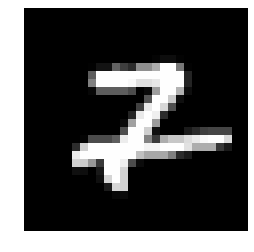

5 8 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.82799301e-136   0.00000000e+000   0.00000000e+000
   1.00000000e+000   0.00000000e+000]


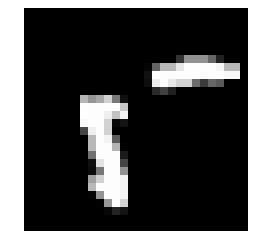

8 3 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   1.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   3.19764487e-142   0.00000000e+000]


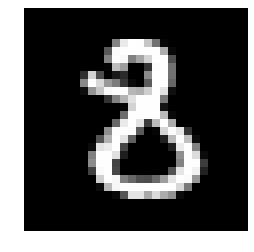

6 7 [  0.00000000e+000   0.00000000e+000   8.36083728e-236   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   1.00000000e+000
   0.00000000e+000   0.00000000e+000]


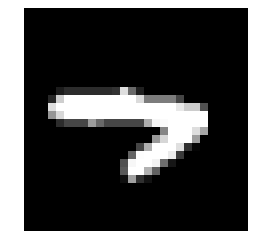

3 8 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


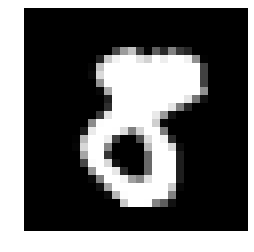

1 8 [  0.00000000e+000   2.13860559e-209   0.00000000e+000   3.69020662e-281
   3.74764592e-267   7.15559225e-097   0.00000000e+000   0.00000000e+000
   1.00000000e+000   2.31490074e-205]


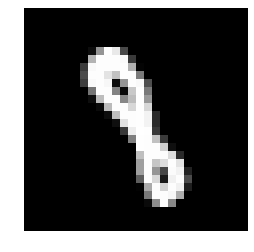

0 8 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


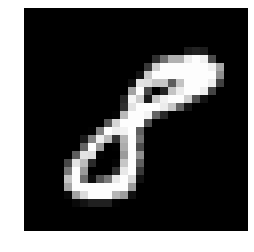

1 0 [  1.00000000e+000   0.00000000e+000   2.47264663e-270   0.00000000e+000
   0.00000000e+000   0.00000000e+000   1.90193531e-284   0.00000000e+000
   0.00000000e+000   0.00000000e+000]


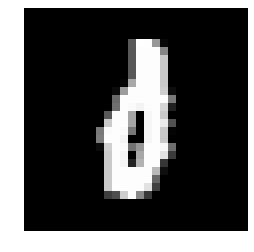

8 3 [  0.00000000e+000   0.00000000e+000   1.25456109e-112   1.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000]


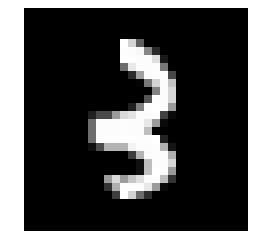

9 5 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   2.76131649e-198
   0.00000000e+000   1.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000]


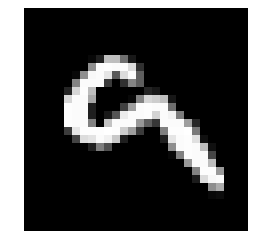

6 8 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   4.69971238e-208
   0.00000000e+000   1.31134445e-156   8.46471303e-129   0.00000000e+000
   1.00000000e+000   0.00000000e+000]


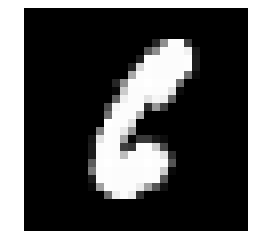

6 0 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


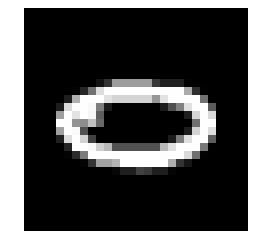

5 0 [  1.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.67162530e-199   3.10238817e-215   0.00000000e+000
   0.00000000e+000   0.00000000e+000]


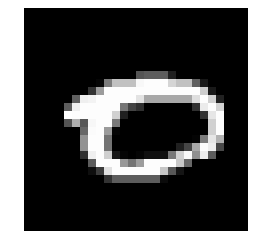

4 9 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   5.24784156e-139   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.00000000e+000]


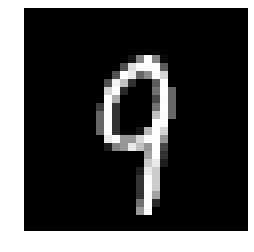

2 4 [  0.00000000e+000   0.00000000e+000   1.68885881e-112   0.00000000e+000
   1.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000]


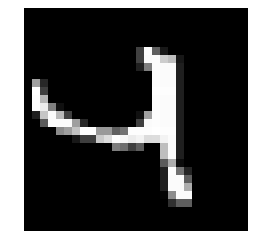

9 7 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.68103531e-295   0.00000000e+000   0.00000000e+000   1.00000000e+000
   0.00000000e+000   1.68880464e-083]


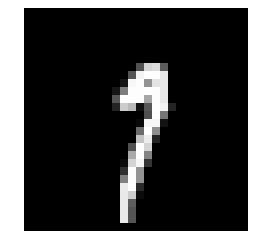

9 4 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   1.75309537e-91]


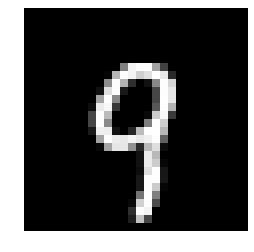

6 8 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


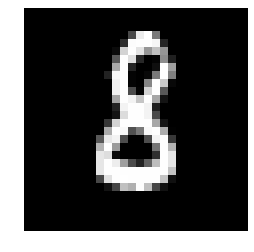

9 4 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   5.30654724e-148]


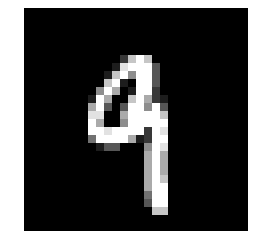

5 6 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   5.30373674e-164   1.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000]


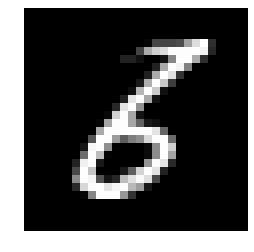

0 5 [  5.43227172e-204   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.00000000e+000   8.87432403e-055   0.00000000e+000
   7.99298908e-265   0.00000000e+000]


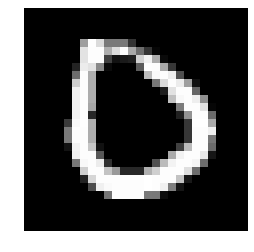

8 3 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   1.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   4.50711626e-205   0.00000000e+000]


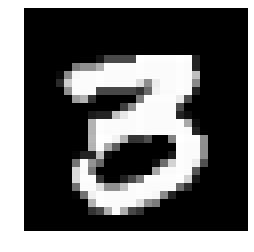

2 1 [  0.00000000e+000   1.00000000e+000   3.96357138e-246   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000]


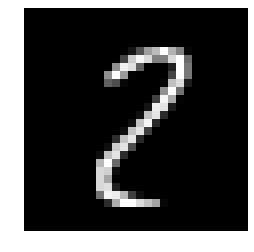

4 9 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   4.69053135e-08   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   9.99999953e-01]


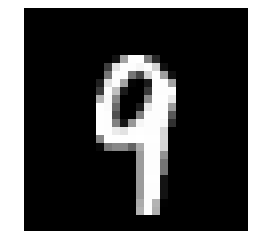

0 8 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   2.63906123e-159   0.00000000e+000   0.00000000e+000
   1.00000000e+000   0.00000000e+000]


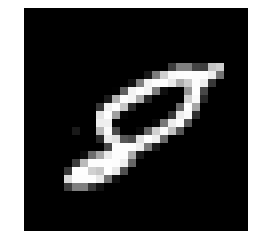

9 4 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.00000000e+000   1.52221046e-038   1.48522059e-275   0.00000000e+000
   0.00000000e+000   3.15188308e-153]


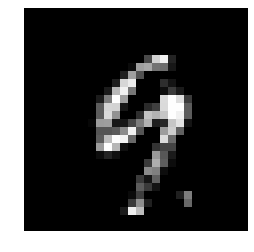

8 4 [  0.00000000e+000   8.09443988e-098   0.00000000e+000   1.00248782e-147
   1.00000000e+000   1.98937500e-020   0.00000000e+000   0.00000000e+000
   5.37759834e-075   4.75105709e-092]


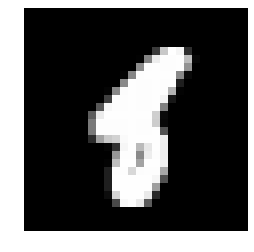

4 9 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   9.63386197e-194   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.00000000e+000]


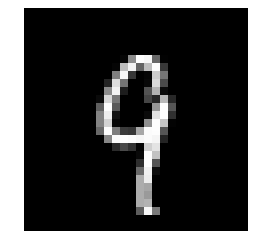

8 0 [  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   3.26824704e-30   0.00000000e+00]


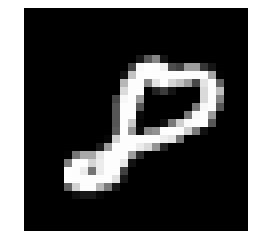

6 5 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]


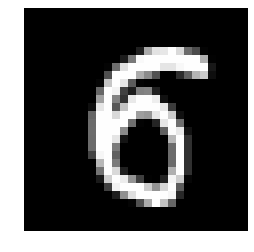

4 1 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]


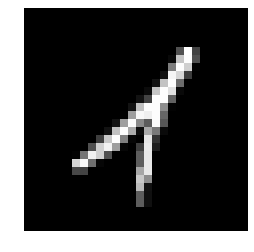

5 3 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]


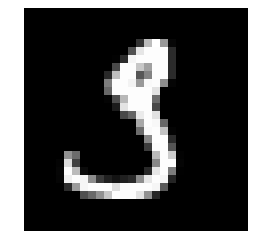

4 9 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   3.41340922e-070   0.00000000e+000   0.00000000e+000   3.90057447e-291
   0.00000000e+000   1.00000000e+000]


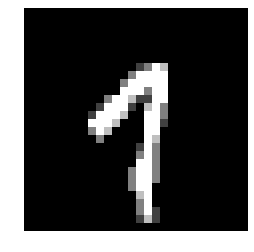

5 9 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]


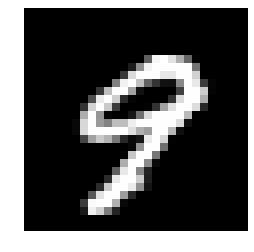

4 7 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.76049491e-304   0.00000000e+000   0.00000000e+000   1.00000000e+000
   0.00000000e+000   0.00000000e+000]


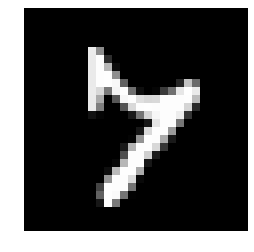

4 6 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.72676132e-150   0.00000000e+000   1.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000]


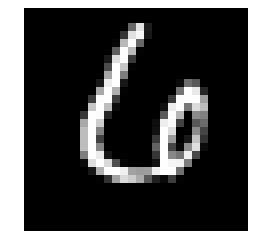

4 9 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]


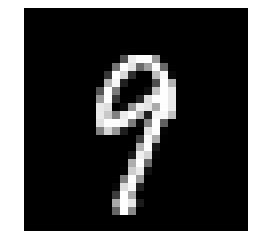

9 8 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   5.10482825e-263   0.00000000e+000   0.00000000e+000   6.25259266e-277
   1.00000000e+000   0.00000000e+000]


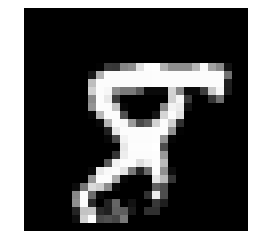

7 9 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   6.05743107e-134
   0.00000000e+000   1.00000000e+000]


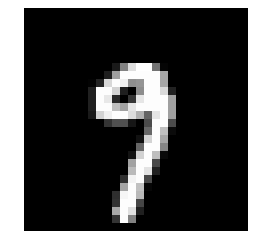

8 3 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   1.00000000e+000
   0.00000000e+000   1.69932171e-289   0.00000000e+000   0.00000000e+000
   3.07154135e-081   0.00000000e+000]


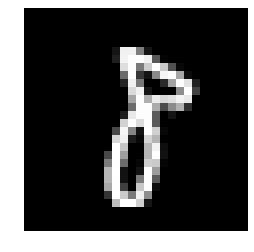

4 2 [  0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
   2.18542596e-10   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00]


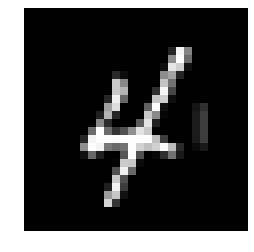

8 2 [  0.00000000e+000   0.00000000e+000   1.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.88755181e-102   0.00000000e+000]


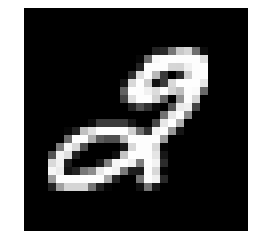

6 4 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]


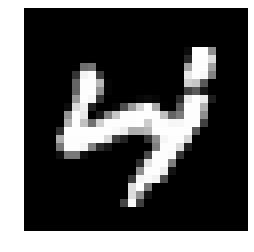

4 1 [  0.00000000e+000   1.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   6.29129968e-162
   0.00000000e+000   0.00000000e+000]


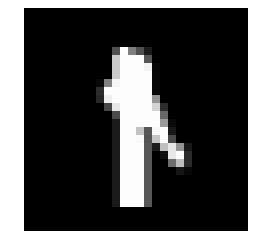

5 6 [  7.90734927e-237   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   6.75190970e-105   1.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000]


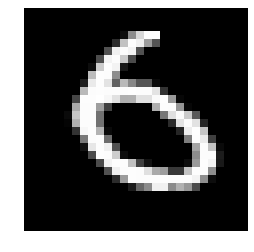

6 8 [  7.75217979e-254   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   5.61871510e-097   0.00000000e+000
   1.00000000e+000   0.00000000e+000]


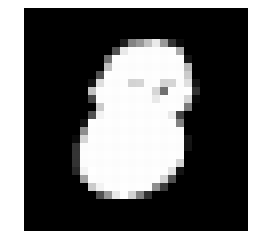

5 6 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]


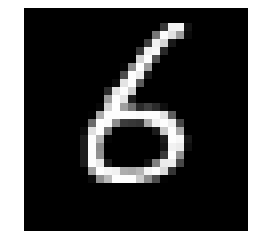

9 4 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]


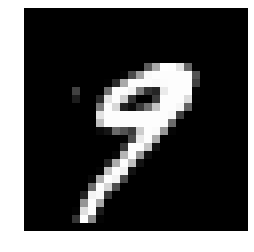

2 8 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


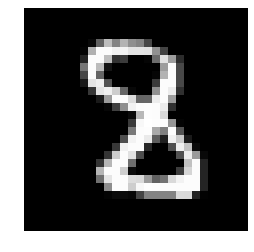

9 4 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]


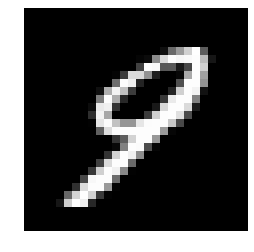

0 2 [  6.31216748e-017   0.00000000e+000   1.00000000e+000   0.00000000e+000
   5.09904738e-194   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.54179399e-169   4.19040133e-058]


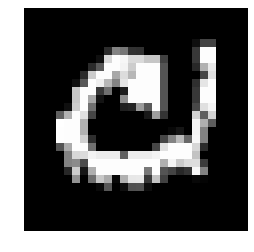

0 1 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]


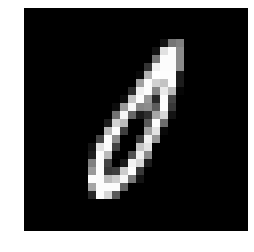

9 4 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   3.43358075e-27]


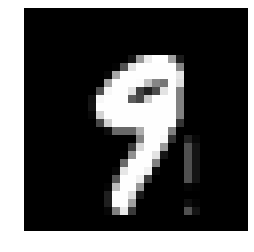

0 6 [  1.24310006e-136   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   1.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000]


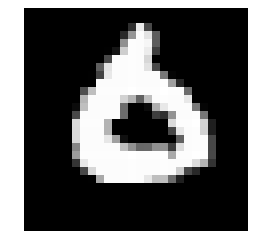

2 7 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


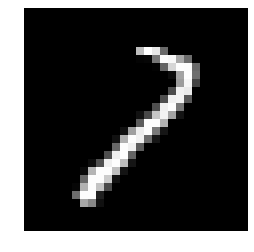

5 8 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   6.27412461e-160   0.00000000e+000   0.00000000e+000
   1.00000000e+000   0.00000000e+000]


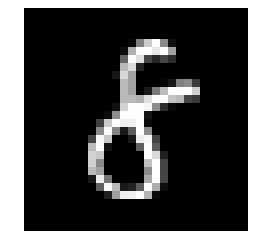

9 4 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]


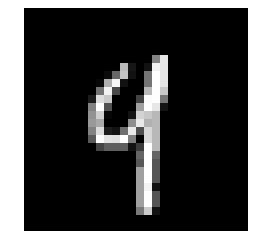

5 9 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   1.20097489e-198
   0.00000000e+000   1.07263031e-227   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.00000000e+000]


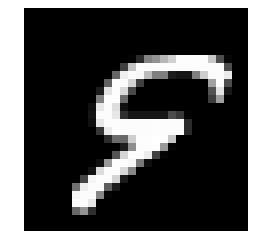

1 6 [  5.23738217e-253   1.14811215e-059   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   1.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000]


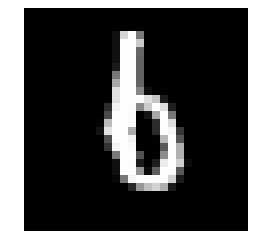

9 7 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
   0.00000000e+00   3.19764280e-45]


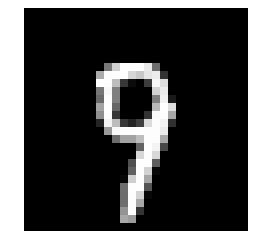

5 6 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]


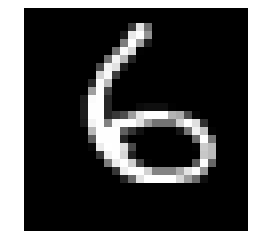

2 4 [  0.00000000e+000   0.00000000e+000   9.61385958e-245   0.00000000e+000
   1.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000]


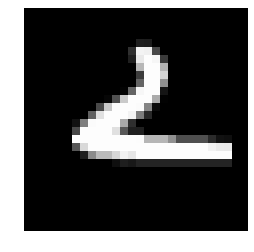

2 4 [  1.12543476e-274   2.77020878e-137   1.30290125e-015   8.29842740e-292
   1.00000000e+000   0.00000000e+000   3.76626392e-294   0.00000000e+000
   0.00000000e+000   0.00000000e+000]


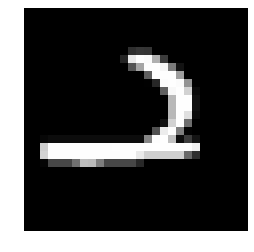

2 4 [  5.53376957e-301   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000]


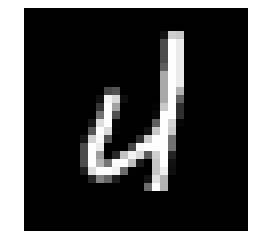

3 5 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   2.69155048e-91
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00]


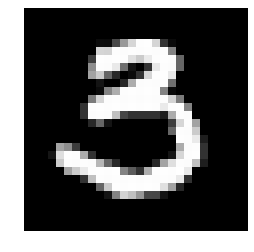

3 2 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]


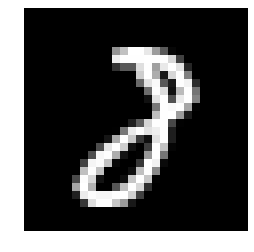

8 4 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.38502272e-265   8.79876910e-129]


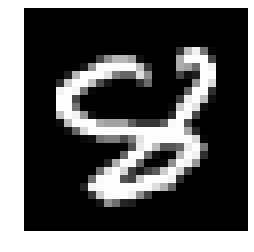

5 9 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   5.00647476e-273
   0.00000000e+000   9.83296444e-031   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.00000000e+000]


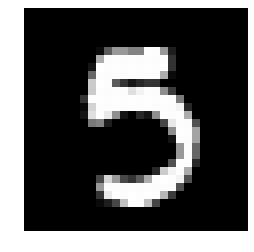

4 9 [ 0.          0.          0.          0.          0.01110769  0.          0.
  0.          0.          0.98889231]


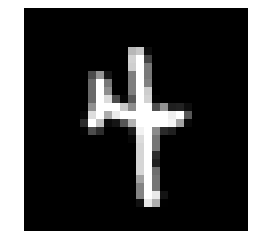

9 1 [  0.00000000e+000   1.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.43970089e-298]


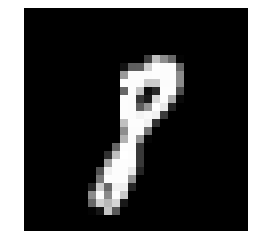

9 7 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
   0.00000000e+00   8.30024934e-91]


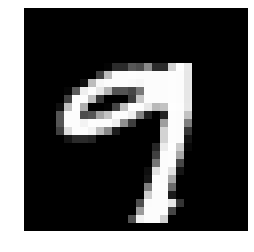

6 8 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


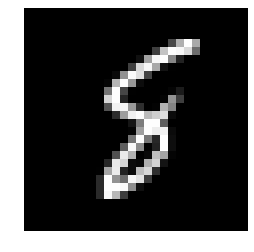

0 6 [  3.82231726e-063   1.51653774e-116   0.00000000e+000   8.11218606e-208
   4.73941071e-200   6.92059929e-204   1.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000]


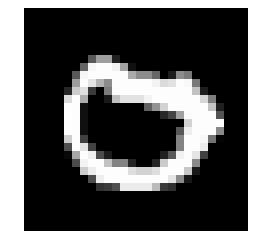

4 7 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   4.57150969e-172   0.00000000e+000   0.00000000e+000   1.00000000e+000
   0.00000000e+000   0.00000000e+000]


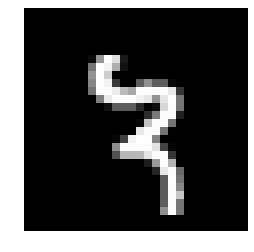

8 3 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   1.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   3.80595032e-157   0.00000000e+000]


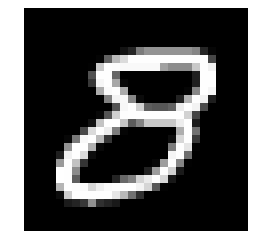

6 8 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   5.18898579e-105   5.44483884e-155   0.00000000e+000
   1.00000000e+000   0.00000000e+000]


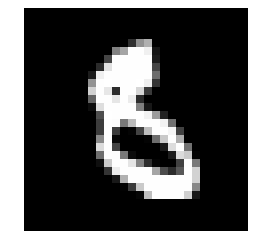

3 5 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   6.14169662e-134
   0.00000000e+000   1.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000]


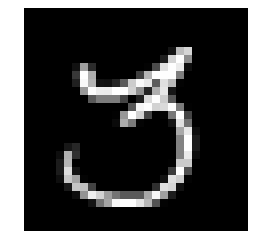

4 9 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   3.71477597e-141   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.00000000e+000]


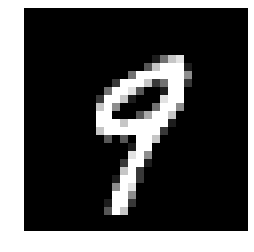

4 9 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.86228190e-056   3.92788933e-305   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.00000000e+000]


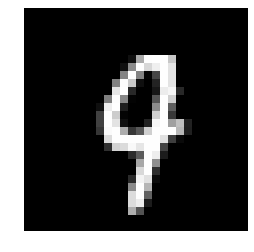

8 0 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


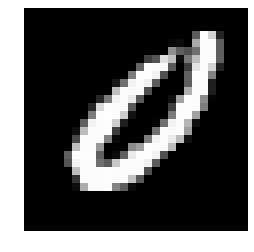

9 5 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]


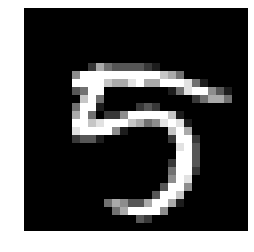

9 4 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.96953542e-168]


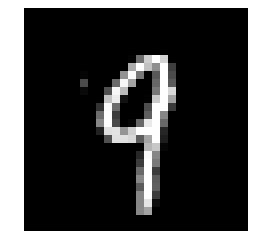

2 7 [  0.00000000e+000   0.00000000e+000   1.24314198e-234   7.67175636e-176
   0.00000000e+000   0.00000000e+000   0.00000000e+000   1.00000000e+000
   0.00000000e+000   0.00000000e+000]


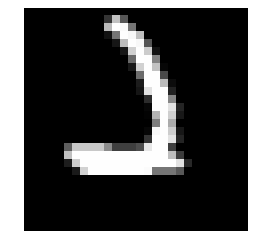

9 4 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   1.34257941e-58]


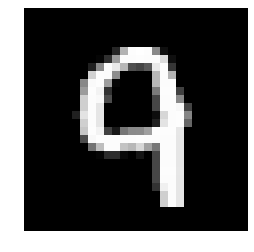

4 9 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]


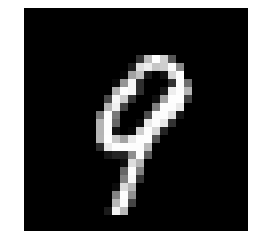

2 7 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   1.25374821e-271
   0.00000000e+000   0.00000000e+000   0.00000000e+000   1.00000000e+000
   0.00000000e+000   0.00000000e+000]


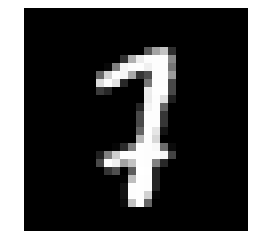

4 9 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   3.39359336e-240   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.00000000e+000]


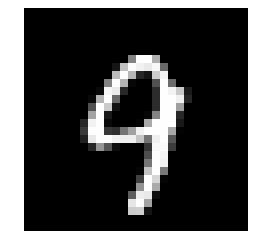

5 8 [  0.00000000e+000   0.00000000e+000   3.73978056e-120   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   2.19603617e-122
   1.00000000e+000   0.00000000e+000]


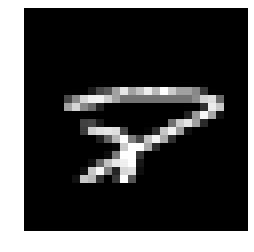

0 9 [  1.01334588e-041   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   6.27474168e-232
   0.00000000e+000   1.00000000e+000]


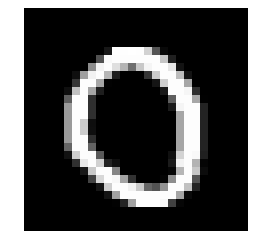

6 5 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]


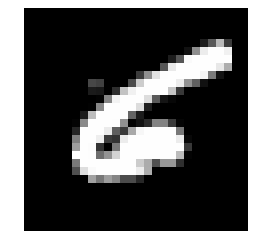

4 9 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]


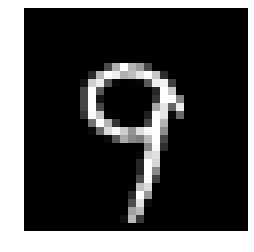

3 5 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   3.44988391e-101
   0.00000000e+000   1.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000]


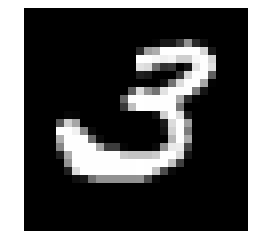

9 8 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


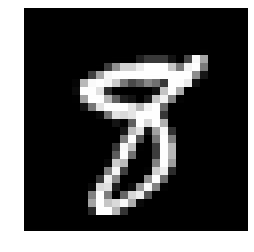

9 7 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   5.24825490e-246   0.00000000e+000   0.00000000e+000   1.00000000e+000
   0.00000000e+000   3.93645754e-160]


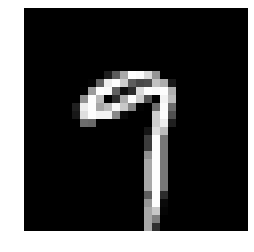

7 2 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]


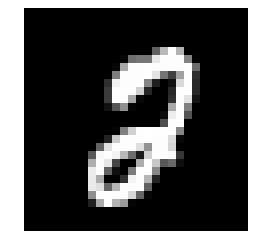

1 0 [  1.00000000e+000   1.54038621e-127   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000]


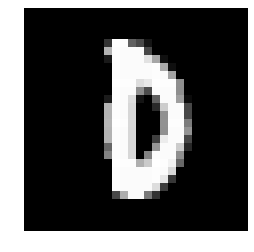

0 1 [  2.55526242e-194   1.00000000e+000   6.51048550e-158   7.21673920e-173
   0.00000000e+000   0.00000000e+000   6.59335160e-188   0.00000000e+000
   4.16604959e-276   0.00000000e+000]


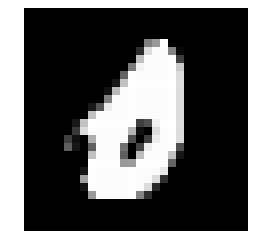

3 7 [  0.00000000e+000   0.00000000e+000   4.35009999e-113   3.21987488e-125
   0.00000000e+000   0.00000000e+000   0.00000000e+000   1.00000000e+000
   0.00000000e+000   0.00000000e+000]


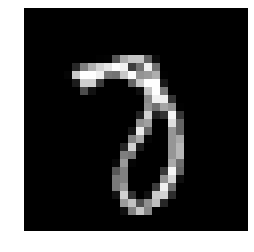

4 3 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   1.00000000e+000
   3.23912123e-274   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.72496441e-037   0.00000000e+000]


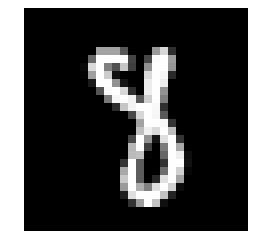

6 8 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.90365756e-14   0.00000000e+00
   1.00000000e+00   0.00000000e+00]


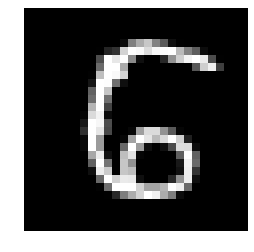

2 1 [  6.38582690e-286   1.00000000e+000   6.16867992e-199   0.00000000e+000
   6.19167834e-253   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.21074649e-270]


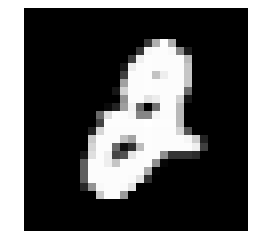

1 7 [  0.00000000e+00   8.74326400e-33   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
   0.00000000e+00   0.00000000e+00]


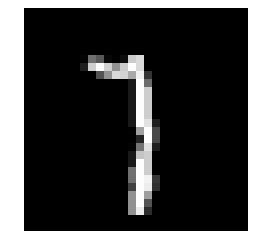

3 9 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   4.99295214e-026
   5.19738591e-058   0.00000000e+000   0.00000000e+000   0.00000000e+000
   8.43196610e-299   1.00000000e+000]


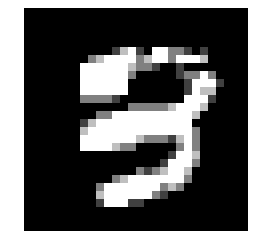

1 8 [  0.00000000e+000   2.99776486e-042   5.57059246e-155   1.22029042e-195
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.00000000e+000   0.00000000e+000]


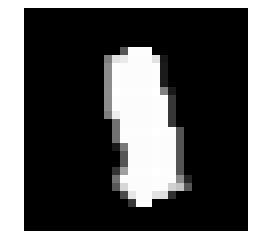

3 9 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]


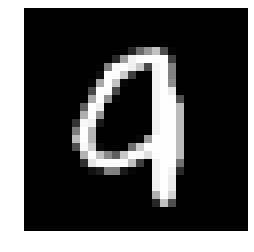

3 8 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   7.80129581e-170   0.00000000e+000
   1.00000000e+000   0.00000000e+000]


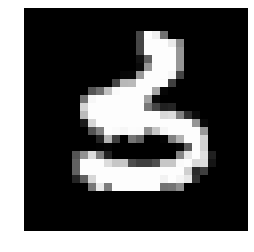

8 6 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]


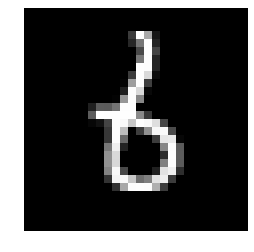

8 4 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   2.85824168e-67   9.05952948e-31]


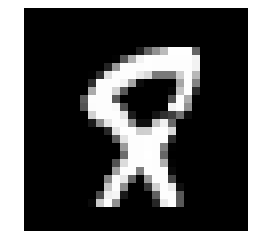

2 3 [  0.00000000e+000   0.00000000e+000   3.70960063e-171   1.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000]


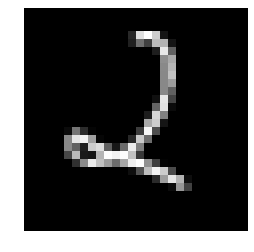

9 4 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]


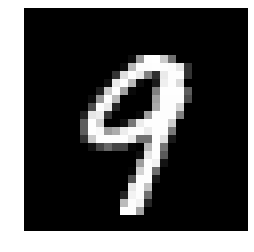

7 9 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   8.06356020e-07
   0.00000000e+00   9.99999194e-01]


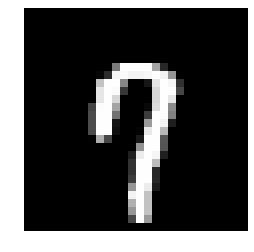

5 6 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.65923703e-178   1.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000]


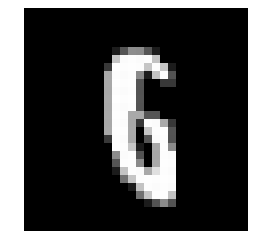

0 6 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   1.00000000e+000   0.00000000e+000
   2.17837534e-287   0.00000000e+000]


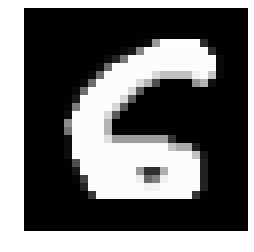

4 8 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   6.36714777e-76   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00]


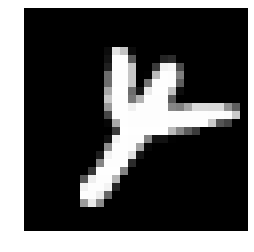

9 7 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.98849168e-048   0.00000000e+000   0.00000000e+000   1.00000000e+000
   0.00000000e+000   1.48884317e-230]


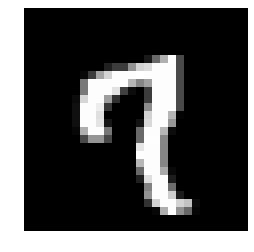

9 7 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


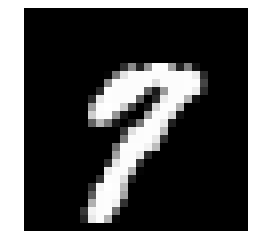

8 5 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   1.00000000e+000   0.00000000e+000   0.00000000e+000
   8.87137680e-111   0.00000000e+000]


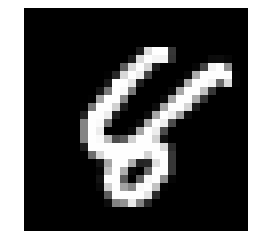

9 4 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]


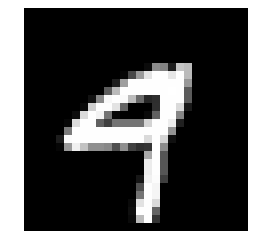

In [81]:
[pred_weights[i].argmax(-1) for i in range(8000) if predictions[i]==3]
for i in range(8000):
    if predictions[i] != pred_weights[i].argmax(-1):
        print (predictions[i],pred_weights[i].argmax(-1), np.vectorize(float)(pred_weights[i]))
        draw_digit(test[i])
        

In [85]:
wrong2 = [i for i in range(8000) if val_weights[i].argmax(-1) != y_val[i]]
print (len(wrong),len(wrong2))

208 215


In [89]:
val_weights

Softmax.0

In [29]:
from lasagne.layers import DenseLayer
from lasagne.layers import InputLayer
from lasagne.layers import DropoutLayer
from lasagne.layers import Conv2DLayer
from lasagne.layers import MaxPool2DLayer
from lasagne.nonlinearities import softmax
from lasagne.updates import adam
from lasagne.layers import get_all_params

from nolearn.lasagne import NeuralNet
from nolearn.lasagne import TrainSplit
from nolearn.lasagne import objective

In [66]:
layers0 = [
    # layer dealing with the input data
    (InputLayer, {'shape': (None,X.shape[1],X.shape[2],X.shape[3])}),

    # first stage of our convolutional layers
    (Conv2DLayer, {'num_filters': 96, 'filter_size': 5}),
    (Conv2DLayer, {'num_filters': 96, 'filter_size': 3}),
    (Conv2DLayer, {'num_filters': 96, 'filter_size': 3}),
    (Conv2DLayer, {'num_filters': 96, 'filter_size': 3}),
    (Conv2DLayer, {'num_filters': 96, 'filter_size': 3}),
    (MaxPool2DLayer, {'pool_size': 2}),

    # second stage of our convolutional layers
    (Conv2DLayer, {'num_filters': 128, 'filter_size': 3}),
    (Conv2DLayer, {'num_filters': 128, 'filter_size': 3}),
    (Conv2DLayer, {'num_filters': 128, 'filter_size': 3}),
    (MaxPool2DLayer, {'pool_size': 2}),

    # two dense layers with dropout
    (DenseLayer, {'num_units': 64}),
    (DropoutLayer, {}),
    (DenseLayer, {'num_units': 64}),

    # the output layer
    (DenseLayer, {'num_units': 10, 'nonlinearity': softmax}),
]

In [69]:
net0 = NeuralNet(
    layers=layers0,
    max_epochs=10,

    update=adam,
    update_learning_rate=0.0002,


    train_split=TrainSplit(eval_size=0.25),
    verbose=1,
)

In [72]:
net0 = NeuralNet(
    layers = [
    # layer dealing with the input data
    ('input',InputLayer), 

    # first stage of our convolutional layers
    ('conv1',Conv2DLayer),
    ('conv2',Conv2DLayer), 
    ('conv3',Conv2DLayer),
    ('conv4',Conv2DLayer),
    ('conv5',Conv2DLayer),
    ('pool1',MaxPool2DLayer),

    # second stage of our convolutional layers
    ('conv6',Conv2DLayer),
    ('conv7',Conv2DLayer),
    ('conv8',Conv2DLayer),
    ('pool2',MaxPool2DLayer),

    # two dense layers with dropout
    ('hid1',DenseLayer),
    ('drop',DropoutLayer), 
    ('hid2',DenseLayer), 

    # the output layer
    ('output',DenseLayer),
    ]
    input_shape = (None,1,28,28),
    
    conv1_num_filters = 96,
    conv1_filter_size = (3,3),
    conv2_num_filters = 96,
    conv2_filter_size = (3,3),
    conv3_num_filters = 96,
    conv3_filter_size = (3,3),
    conv4_num_filters = 96,
    conv4_filter_size = (3,3),
    conv5_num_filters = 96,
    conv5_filter_size = (3,3),
    
    pool1_pool_size = (2,2),
    
    conv6_num_filters = 128,
    conv6_filter_size = (3,3),
    conv7_num_filters = 128,
    conv7_filter_size = (3,3),
    conv8_num_filters = 128,
    conv8_filter_size = (3,3),    

    
    pool2_pool_size = (2,2),

    hid1_num_units = 64,
    
    drop_p = 0.5,
    
    hid2_num_units = 64,
    
    output_num_units = 10
    output_nonlinearity = softmax
    
    max_epochs=10,
    update=lasagne.updates.sgd,
    update_learning_rate=0.0001,
    verbose=1,
    )

#    objective=regularization_objective,
#    objective_lambda2=0.0025,
#    train_split=TrainSplit(eval_size=0.25),


SyntaxError: invalid syntax (<ipython-input-72-cde2128ce649>, line 28)

In [71]:
print X.shape
print y.shape

(32000L, 1L, 28L, 28L)
(32000L,)


In [73]:
net0.fit(X, y)

NotImplementedError: In() instances and tuple inputs trigger the old semantics, which disallow using updates and givens

In [46]:
y.shape

(32000L,)

SyntaxError: unexpected EOF while parsing (<ipython-input-53-79bd47eb07bd>, line 1)